In [2]:
from keras.layers import Input, Dense, Activation, Dropout, LeakyReLU, Lambda, PReLU
from keras.models import Model, Sequential, model_from_json
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras import optimizers, activations, regularizers, losses
from keras import backend as K
from sklearn.model_selection import train_test_split, KFold
#from sklearn.datasets import make_regression
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py

Using TensorFlow backend.


## ROM Data Processing and Splitting

In [3]:
'''Import data'''

# File path
data = h5py.File('/Users/maggiezhang/Dropbox/AtmosphereMachineLearning/DensityData/JB2008_1999_2010_ROM_r100.mat', 'r')

# Reduced-order density data
dens_data = data.get('densityDataLogVarROM100')
dens_data = np.array(dens_data)

# Space weather data
sw_data = data.get('SWdataFull')
sw_data = np.array(sw_data)
sw_data = sw_data.transpose()
print(sw_data.shape)
sw_col_names = ["doy", "UThrs", "F10", "F10B", "S10", "S10B", "XM10", "XM10B", "Y10", "Y10B", "DSTDTC", "GWRAS", "SUN(1)", "SUN(2)"]
df = pd.DataFrame(sw_data, columns = sw_col_names)
print(df.head())


pred_number = 72

# Only consider first 10 modes/dimensions of reduced data
dens_data = dens_data[:,0:10]


'''Training data'''
# Training input

# Testing the 70, 15, 15 for train, val, test 

split_15 = int(dens_data.shape[0]*0.85) # manual test split 

dens_data_train = dens_data[0:split_15-pred_number,:]
sw_data_train = sw_data[0:split_15-pred_number,:]
sw_data_train_append = sw_data[1:split_15-pred_number+1,:] #looks at next sw timestep because it could be useful in prediction 
sw_data_train = np.concatenate((sw_data_train, sw_data_train_append), axis=1)
# Input is reduced-order density and space weather data
x_train = np.concatenate((dens_data_train, sw_data_train), axis=1)
print(x_train.shape)
# TODO: we could also add the SW data of the next time step if that perform better

# Training output
# Output is reduced-order density data at next time step
y_train = dens_data[1:split_15-pred_number+1,:]

'''ROM LINEAR MATRICES''' 
Om = np.append(np.transpose(dens_data_train), np.transpose(sw_data_train), axis = 0)
X2 = np.transpose(y_train)

# Compute dynamic matrices:
# Phi = X2*pinv(Om)
Phi = np.matmul(X2,np.linalg.pinv(Om))

r = 10 #reduced order 
A = Phi[:r, :r]
B = Phi[:r, r:]

'''Test data'''
# Test input
print(dens_data.shape)
dens_data_test = dens_data[split_15-pred_number-1:-pred_number-2,:]
sw_data_test = sw_data[split_15-pred_number-1:-pred_number-2,:]
sw_data_test_append = sw_data[split_15-pred_number:-pred_number-1,:]
sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
# Input is reduced-order density and space weather data
print(sw_data_test.shape)
print(dens_data_test.shape)
x_test = np.concatenate((dens_data_test, sw_data_test), axis=1)
print(x_test.shape)
print(x_test[0])

# Test output
# Output is reduced-order density data at next time step
y_test = dens_data[split_15-pred_number:-pred_number-1,:]
print(y_test.shape)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.17647) #, random_state=42)

(103404, 14)
    doy  UThrs    F10   F10B    S10   S10B   XM10  XM10B    Y10   Y10B  \
0  75.0   12.0  150.1  129.7  150.5  137.6  158.1  130.7  148.8  138.7   
1  75.0   13.0  150.1  129.7  150.5  137.6  158.1  130.7  148.8  138.7   
2  75.0   14.0  150.1  129.7  150.5  137.6  158.1  130.7  148.8  138.7   
3  75.0   15.0  150.1  129.7  150.5  137.6  158.1  130.7  148.8  138.7   
4  75.0   16.0  150.1  129.7  150.5  137.6  158.1  130.7  148.8  138.7   

   DSTDTC     GWRAS    SUN(1)    SUN(2)  
0    17.5  6.172181 -0.072585 -0.031433  
1    38.5  0.151512 -0.071919 -0.031146  
2    38.5  0.414028 -0.071254 -0.030859  
3    38.5  0.676544 -0.070589 -0.030571  
4    38.5  0.939060 -0.069923 -0.030284  
(87821, 38)
(103404, 10)
(15510, 28)
(15510, 10)
(15510, 38)
[ 1.02007241e+02  1.79899320e+00 -2.00131745e+00  4.04272418e+00
  2.71923635e-01  5.69029149e-01 -4.92334671e-01  8.79451742e-01
 -7.49803489e-02 -2.39028651e-01  8.10000000e+01  1.60000000e+01
  7.01000000e+01  6.96000000e+01  

## Original Model with 3 Leaky layers of 0.3

In [138]:
'''Create NN'''
def swish(x, beta=1.0):
    return x * K.sigmoid(beta * x)

def leaky_relu6(x):
    return K.relu(x, alpha = 0.3)

model = Sequential()
model.add(Dense(120, kernel_initializer='random_uniform'))
#kernel_regularizer=regularizers.l2(0.01)
#model.add(Activation(swish))
model.add(LeakyReLU(alpha=0.3))
#model.add(Activation('tanh'))
model.add(Dense(40, kernel_initializer='random_uniform'))
#model.add(Activation(swish))
model.add(LeakyReLU(alpha=0.3))
#model.add(Activation('sigmoid'))
model.add(Dense(20, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(10, kernel_initializer='random_uniform'))


Train on 87821 samples, validate on 15507 samples
Epoch 1/500
87821/87821 [==============================] - 3s 30us/step - loss: 17.6867 - accuracy: 0.9205 - val_loss: 0.8755 - val_accuracy: 0.9672
Epoch 2/500
87821/87821 [==============================] - 2s 28us/step - loss: 0.5717 - accuracy: 0.9628 - val_loss: 0.5365 - val_accuracy: 0.9578
Epoch 3/500
87821/87821 [==============================] - 2s 28us/step - loss: 0.3878 - accuracy: 0.9627 - val_loss: 0.3755 - val_accuracy: 0.9580
Epoch 4/500
87821/87821 [==============================] - 2s 27us/step - loss: 0.3150 - accuracy: 0.9650 - val_loss: 0.3929 - val_accuracy: 0.9663
Epoch 5/500
87821/87821 [==============================] - 2s 28us/step - loss: 0.2246 - accuracy: 0.9713 - val_loss: 0.1747 - val_accuracy: 0.9756
Epoch 6/500
87821/87821 [==============================] - 2s 28us/step - loss: 0.1616 - accuracy: 0.9779 - val_loss: 0.1341 - val_accuracy: 0.9821
Epoch 7/500
87821/87821 [==============================] - 2s

Epoch 56/500
87821/87821 [==============================] - 2s 28us/step - loss: 0.0147 - accuracy: 0.9956 - val_loss: 0.0180 - val_accuracy: 0.9940
Epoch 57/500
87821/87821 [==============================] - 3s 30us/step - loss: 0.0147 - accuracy: 0.9954 - val_loss: 0.0151 - val_accuracy: 0.9964
Epoch 58/500
87821/87821 [==============================] - 3s 30us/step - loss: 0.0148 - accuracy: 0.9956 - val_loss: 0.0181 - val_accuracy: 0.9963
Epoch 59/500
87821/87821 [==============================] - 3s 30us/step - loss: 0.0139 - accuracy: 0.9957 - val_loss: 0.0090 - val_accuracy: 0.9979
Epoch 60/500
87821/87821 [==============================] - 3s 30us/step - loss: 0.0143 - accuracy: 0.9955 - val_loss: 0.0450 - val_accuracy: 0.9957
Epoch 61/500
87821/87821 [==============================] - 3s 30us/step - loss: 0.0146 - accuracy: 0.9958 - val_loss: 0.0189 - val_accuracy: 0.9954
Epoch 62/500
87821/87821 [==============================] - 3s 31us/step - loss: 0.0134 - accuracy: 0.9959

Epoch 111/500
87821/87821 [==============================] - 3s 31us/step - loss: 0.0081 - accuracy: 0.9967 - val_loss: 0.0066 - val_accuracy: 0.9955
Epoch 112/500
87821/87821 [==============================] - 3s 30us/step - loss: 0.0077 - accuracy: 0.9962 - val_loss: 0.0057 - val_accuracy: 0.9958
Epoch 113/500
87821/87821 [==============================] - 3s 29us/step - loss: 0.0086 - accuracy: 0.9965 - val_loss: 0.0083 - val_accuracy: 0.9957
Epoch 114/500
87821/87821 [==============================] - 3s 30us/step - loss: 0.0081 - accuracy: 0.9965 - val_loss: 0.0057 - val_accuracy: 0.9973
Epoch 115/500
87821/87821 [==============================] - 3s 29us/step - loss: 0.0078 - accuracy: 0.9967 - val_loss: 0.0057 - val_accuracy: 0.9959
Epoch 116/500
87821/87821 [==============================] - 2s 28us/step - loss: 0.0081 - accuracy: 0.9962 - val_loss: 0.0036 - val_accuracy: 0.9986
Epoch 117/500
87821/87821 [==============================] - 2s 28us/step - loss: 0.0078 - accuracy:

Epoch 220/500
87821/87821 [==============================] - 2s 28us/step - loss: 0.0053 - accuracy: 0.9971 - val_loss: 0.0042 - val_accuracy: 0.9968
Epoch 221/500
87821/87821 [==============================] - 2s 27us/step - loss: 0.0050 - accuracy: 0.9973 - val_loss: 0.0023 - val_accuracy: 0.9981
Epoch 222/500
87821/87821 [==============================] - 2s 27us/step - loss: 0.0050 - accuracy: 0.9968 - val_loss: 0.0072 - val_accuracy: 0.9979
Epoch 223/500
87821/87821 [==============================] - 2s 26us/step - loss: 0.0052 - accuracy: 0.9968 - val_loss: 0.0024 - val_accuracy: 0.9975
Epoch 224/500
87821/87821 [==============================] - 2s 25us/step - loss: 0.0050 - accuracy: 0.9973 - val_loss: 0.0061 - val_accuracy: 0.9984
Epoch 225/500
87821/87821 [==============================] - 2s 25us/step - loss: 0.0047 - accuracy: 0.9973 - val_loss: 0.0080 - val_accuracy: 0.9965
Epoch 226/500
87821/87821 [==============================] - 2s 25us/step - loss: 0.0048 - accuracy:

Epoch 329/500
87821/87821 [==============================] - 2s 26us/step - loss: 0.0042 - accuracy: 0.9974 - val_loss: 0.0030 - val_accuracy: 0.9984
Epoch 330/500
87821/87821 [==============================] - 2s 25us/step - loss: 0.0039 - accuracy: 0.9973 - val_loss: 0.0015 - val_accuracy: 0.9985
Epoch 331/500
87821/87821 [==============================] - 2s 25us/step - loss: 0.0039 - accuracy: 0.9973 - val_loss: 0.0023 - val_accuracy: 0.9990
Epoch 332/500
87821/87821 [==============================] - 2s 26us/step - loss: 0.0038 - accuracy: 0.9972 - val_loss: 0.0030 - val_accuracy: 0.9974
Epoch 333/500
87821/87821 [==============================] - 2s 27us/step - loss: 0.0037 - accuracy: 0.9973 - val_loss: 0.0032 - val_accuracy: 0.9985
Epoch 334/500
87821/87821 [==============================] - 2s 28us/step - loss: 0.0039 - accuracy: 0.9974 - val_loss: 0.0018 - val_accuracy: 0.9988
Epoch 335/500
87821/87821 [==============================] - 3s 30us/step - loss: 0.0039 - accuracy:

Epoch 438/500
87821/87821 [==============================] - 2s 26us/step - loss: 0.0030 - accuracy: 0.9975 - val_loss: 0.0044 - val_accuracy: 0.9954
Epoch 439/500
87821/87821 [==============================] - 2s 26us/step - loss: 0.0033 - accuracy: 0.9977 - val_loss: 0.0083 - val_accuracy: 0.9978
Epoch 440/500
87821/87821 [==============================] - 2s 27us/step - loss: 0.0031 - accuracy: 0.9977 - val_loss: 0.0024 - val_accuracy: 0.9989
Epoch 441/500
87821/87821 [==============================] - 2s 27us/step - loss: 0.0030 - accuracy: 0.9976 - val_loss: 0.0025 - val_accuracy: 0.9985
Epoch 442/500
87821/87821 [==============================] - 2s 27us/step - loss: 0.0034 - accuracy: 0.9975 - val_loss: 0.0020 - val_accuracy: 0.9989
Epoch 443/500
87821/87821 [==============================] - 2s 28us/step - loss: 0.0034 - accuracy: 0.9976 - val_loss: 0.0018 - val_accuracy: 0.9992
Epoch 444/500
87821/87821 [==============================] - 3s 30us/step - loss: 0.0032 - accuracy:

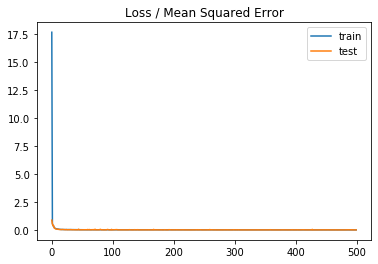

In [139]:
'''Train NN'''
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#rms = optimizers.RMSprop(learning_rate=0.001, rho=0.9)
#early_stop = EarlyStopping(patience=5)
ad = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=ad, loss='mse', metrics=['accuracy'])
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.17647, random_state=42)
history = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs = 500, batch_size = 32) #, callbacks=[early_stop])
#validation_data=(x_test, y_test)
#validation_split=0.25
plt.figure()
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()


## Test NN with leaky relu "#" to cap max value

In [4]:
test_model = Sequential()
#test_model.add(Dense(120, kernel_initializer='random_uniform'))
#model.add(LeakyReLU(alpha=0.3))
test_model.add(Dense(120, kernel_initializer='random_uniform'))
test_model.add(Activation(lambda x: activations.relu(x, max_value = 100, alpha=0.2)))
#test_model.add(PReLU())
#test_model.add(LeakyReLU(alpha=0.3))
test_model.add(Dense(40, kernel_initializer='random_uniform'))
test_model.add(Activation(lambda x: activations.relu(x, max_value = 10, alpha=0.2)))
#test_model.add(PReLU())
#test_model.add(LeakyReLU(alpha=0.3))
test_model.add(Dense(20, kernel_initializer='random_uniform'))
test_model.add(Activation(lambda x: activations.relu(x, max_value = 6, alpha=0.3)))
#test_model.add(PReLU())
#test_model.add(LeakyReLU(alpha=0.3))
test_model.add(Dense(10, kernel_initializer='random_uniform'))

In [5]:
ad = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
test_model.compile(optimizer=ad, loss='mse', metrics=['accuracy'])
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.17647)

history = test_model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs = 500, batch_size = 32) 

Train on 72323 samples, validate on 15498 samples
Epoch 1/500
72323/72323 [==============================] - 2s 33us/step - loss: 32.6049 - accuracy: 0.9072 - val_loss: 5.6294 - val_accuracy: 0.9288
Epoch 2/500
72323/72323 [==============================] - 2s 29us/step - loss: 3.9081 - accuracy: 0.9442 - val_loss: 0.8685 - val_accuracy: 0.9698
Epoch 3/500
72323/72323 [==============================] - 2s 31us/step - loss: 0.6065 - accuracy: 0.9714 - val_loss: 0.4960 - val_accuracy: 0.9752
Epoch 4/500
72323/72323 [==============================] - 2s 33us/step - loss: 0.4557 - accuracy: 0.9731 - val_loss: 0.5854 - val_accuracy: 0.9698
Epoch 5/500
72323/72323 [==============================] - 2s 34us/step - loss: 0.3805 - accuracy: 0.9733 - val_loss: 0.3441 - val_accuracy: 0.9746
Epoch 6/500
72323/72323 [==============================] - 2s 33us/step - loss: 0.2930 - accuracy: 0.9761 - val_loss: 0.2583 - val_accuracy: 0.9811
Epoch 7/500
72323/72323 [==============================] - 2s

Epoch 56/500
72323/72323 [==============================] - 3s 37us/step - loss: 0.0233 - accuracy: 0.9940 - val_loss: 0.0550 - val_accuracy: 0.9902
Epoch 57/500
72323/72323 [==============================] - 2s 34us/step - loss: 0.0227 - accuracy: 0.9943 - val_loss: 0.0190 - val_accuracy: 0.9953
Epoch 58/500
72323/72323 [==============================] - 2s 32us/step - loss: 0.0230 - accuracy: 0.9939 - val_loss: 0.0251 - val_accuracy: 0.9926
Epoch 59/500
72323/72323 [==============================] - 2s 31us/step - loss: 0.0219 - accuracy: 0.9942 - val_loss: 0.0170 - val_accuracy: 0.9928
Epoch 60/500
72323/72323 [==============================] - 2s 31us/step - loss: 0.0221 - accuracy: 0.9944 - val_loss: 0.0298 - val_accuracy: 0.9940
Epoch 61/500
72323/72323 [==============================] - 2s 30us/step - loss: 0.0212 - accuracy: 0.9945 - val_loss: 0.0226 - val_accuracy: 0.9949
Epoch 62/500
72323/72323 [==============================] - 2s 31us/step - loss: 0.0218 - accuracy: 0.9943

Epoch 111/500
72323/72323 [==============================] - 2s 30us/step - loss: 0.0132 - accuracy: 0.9957 - val_loss: 0.0112 - val_accuracy: 0.9964
Epoch 112/500
72323/72323 [==============================] - 2s 30us/step - loss: 0.0121 - accuracy: 0.9959 - val_loss: 0.0236 - val_accuracy: 0.9955
Epoch 113/500
72323/72323 [==============================] - 2s 31us/step - loss: 0.0125 - accuracy: 0.9958 - val_loss: 0.0172 - val_accuracy: 0.9956
Epoch 114/500
72323/72323 [==============================] - 2s 30us/step - loss: 0.0122 - accuracy: 0.9956 - val_loss: 0.0483 - val_accuracy: 0.9886
Epoch 115/500
72323/72323 [==============================] - 2s 30us/step - loss: 0.0118 - accuracy: 0.9956 - val_loss: 0.0142 - val_accuracy: 0.9938
Epoch 116/500
72323/72323 [==============================] - 2s 30us/step - loss: 0.0117 - accuracy: 0.9962 - val_loss: 0.0098 - val_accuracy: 0.9965
Epoch 117/500
72323/72323 [==============================] - 2s 31us/step - loss: 0.0119 - accuracy:

72323/72323 [==============================] - 2s 31us/step - loss: 0.0083 - accuracy: 0.9964 - val_loss: 0.0068 - val_accuracy: 0.9969
Epoch 166/500
72323/72323 [==============================] - 2s 32us/step - loss: 0.0078 - accuracy: 0.9963 - val_loss: 0.0062 - val_accuracy: 0.9951
Epoch 167/500
72323/72323 [==============================] - 2s 32us/step - loss: 0.0077 - accuracy: 0.9968 - val_loss: 0.0085 - val_accuracy: 0.9973
Epoch 168/500
72323/72323 [==============================] - 2s 32us/step - loss: 0.0080 - accuracy: 0.9965 - val_loss: 0.0108 - val_accuracy: 0.9929
Epoch 169/500
72323/72323 [==============================] - 2s 32us/step - loss: 0.0081 - accuracy: 0.9965 - val_loss: 0.0109 - val_accuracy: 0.9968
Epoch 170/500
72323/72323 [==============================] - 2s 32us/step - loss: 0.0074 - accuracy: 0.9968 - val_loss: 0.0069 - val_accuracy: 0.9953
Epoch 171/500
72323/72323 [==============================] - 2s 31us/step - loss: 0.0079 - accuracy: 0.9969 - val_

KeyboardInterrupt: 

## Plot Errors and Save Model to JSON/h5 file

NameError: name 'history' is not defined

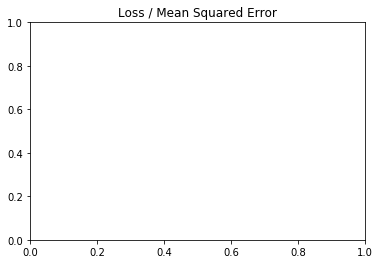

In [6]:
plt.figure()
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

'''
model_json = test_model.to_json()
with open("recurrent_model_16.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("recurrent_model_16.h5")
print("Saved model")
#'''

## Compare errors over recurrent timesteps for test_model
>for pred_number of hrs

/Users/maggiezhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[[3.34864044e-02 1.24543959e-01 2.58763355e-01 4.27125432e-01
  6.27275267e-01 8.58294420e-01 1.12006412e+00 1.41315358e+00
  1.73801147e+00 2.09431979e+00 2.48115946e+00 2.89814342e+00
  3.34418092e+00 3.81838919e+00 4.31911559e+00 4.84542131e+00
  5.39679900e+00 5.97288275e+00 6.57378008e+00 7.19779411e+00
  7.84316648e+00 8.50929478e+00 9.19449851e+00 9.89810957e+00
  1.06198002e+01 1.13594000e+01 1.21173029e+01 1.28958779e+01
  1.36952009e+01 1.45144236e+01 1.53540927e+01 1.62111474e+01
  1.70838035e+01 1.79707594e+01 1.88717034e+01 1.97856493e+01
  2.07119778e+01 2.16492400e+01 2.25955222e+01 2.35508188e+01
  2.45156812e+01 2.54889632e+01 2.64674801e+01 2.74493476e+01
  2.84350083e+01 2.94220197e+01 3.04115563e+01 3.14021575e+01
  3.23932506e+01 3.33844353e+01 3.43756698e+01 3.53672512e+01
  3.63589717e+01 3.73515369e+01 3.83455899e+01 3.93394987e+01
  4.03334646e+01 4.13265028e+01 4.23176597e+01 4.33070513e+01
  4.42941070e+01 4.52770739e+01 4.62557657e+01 4.72286345e+01
  4.8197

/Users/maggiezhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[[0.15169021 0.29783239 0.43715056 0.50523231 0.57302878 0.64065435
  0.68710138 0.7338827  0.78068466 0.81707187 0.8539746  0.89108818
  0.92496238 0.95902251 0.99288629 1.02351357 1.0543831  1.08514296
  1.11622935 1.1473571  1.17839091 1.20868649 1.23856964 1.26807367
  1.29668099 1.32474735 1.35236065 1.38093167 1.40885468 1.43603411
  1.46219763 1.48779101 1.51278338 1.53712151 1.56067109 1.58355228
  1.60366536 1.62365265 1.64322216 1.66280221 1.68210286 1.70089687
  1.71858546 1.73564065 1.75218341 1.76908598 1.78543124 1.80121729
  1.81742707 1.83304571 1.84814575 1.86149542 1.8743971  1.88693058
  1.89933246 1.91148354 1.92335732 1.93462578 1.94555396 1.95614722
  1.96684475 1.97735634 1.98754199 1.99686294 2.00582234 2.01452015
  2.02275356 2.0306897  2.03831955 2.04621402 2.05398393 2.0615951 ]]
[4.52990451 2.39138365 1.68938355 1.18286637 0.91352044 0.74642726
 0.61344826 0.51932268 0.44918269 0.39013711 0.34418368 0.30746863
 0.27658862 0.25115892 0.22988185 0.21123314 0.1

/Users/maggiezhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/maggiezhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


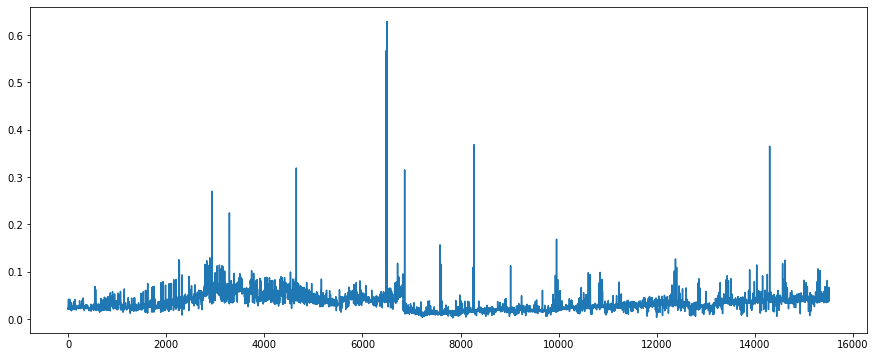

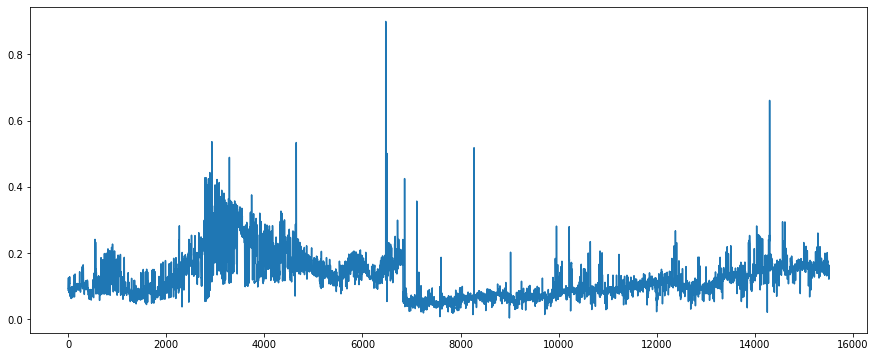

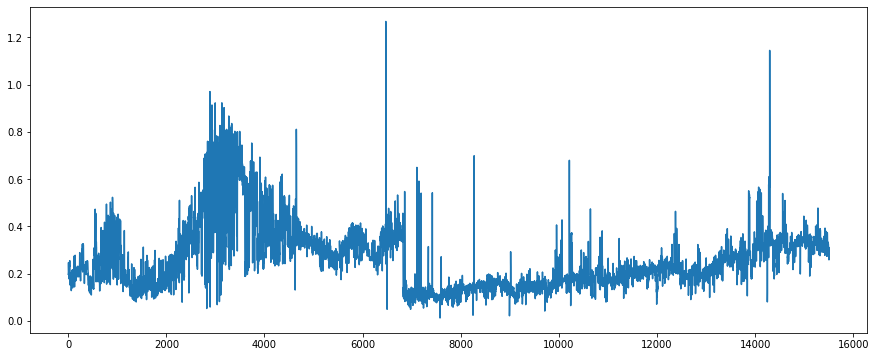

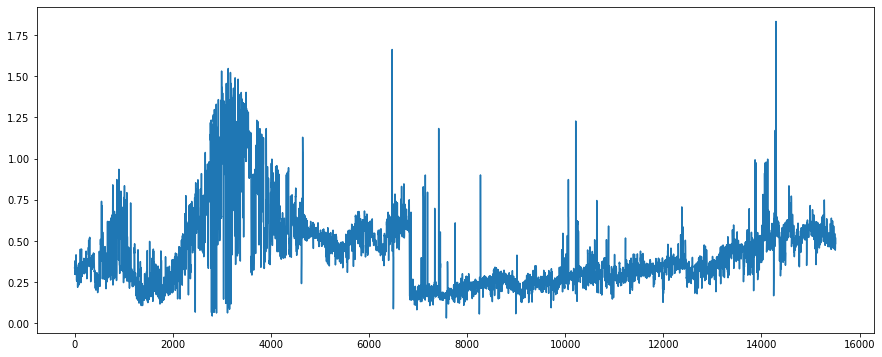

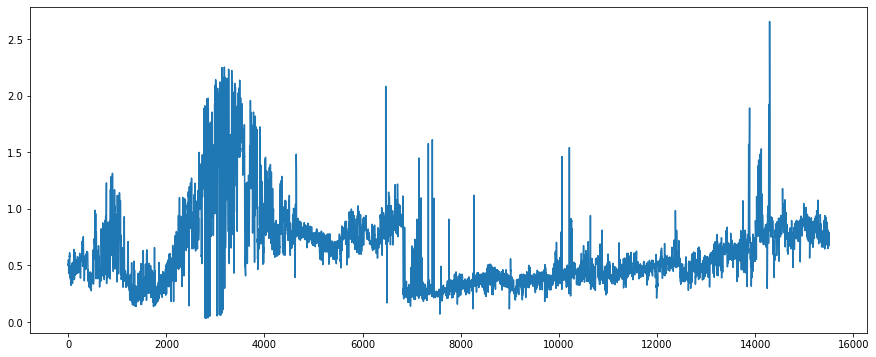

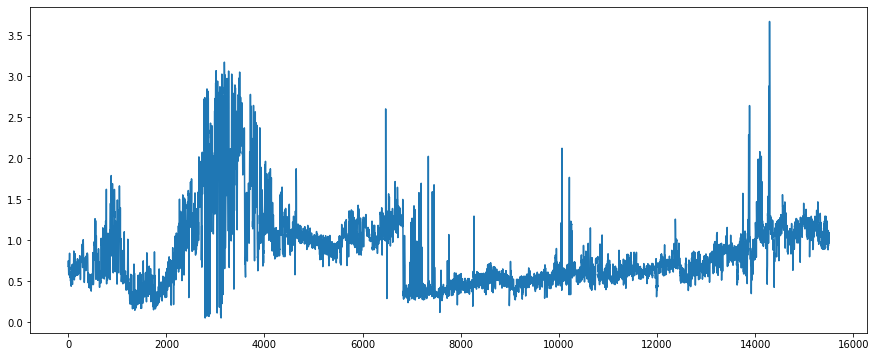

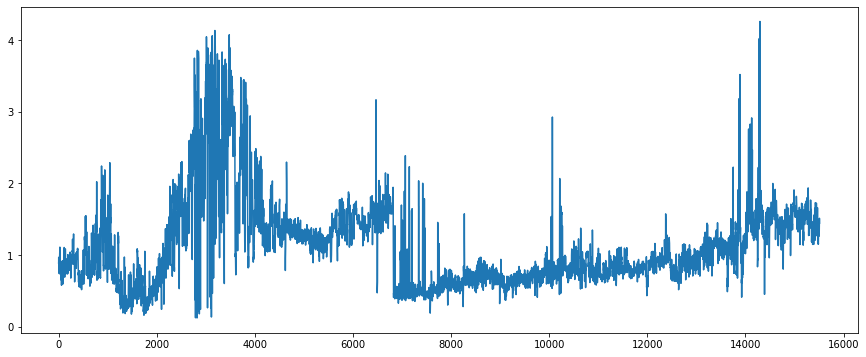

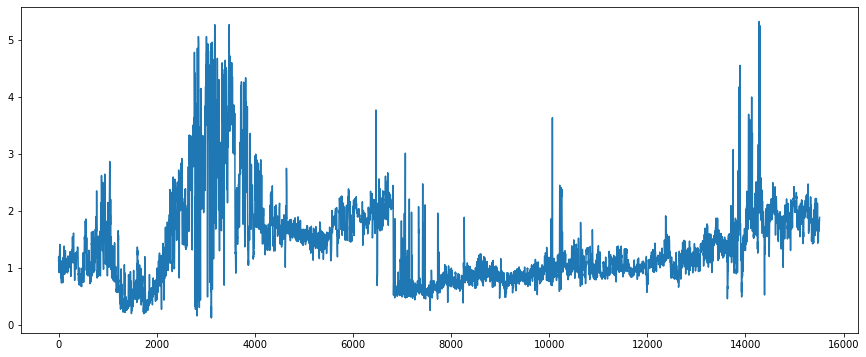

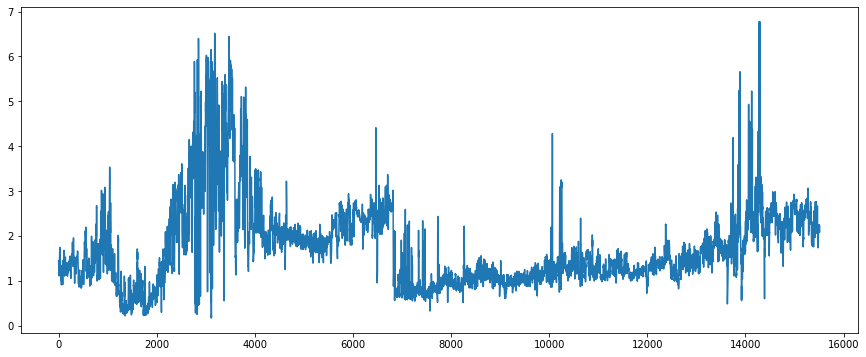

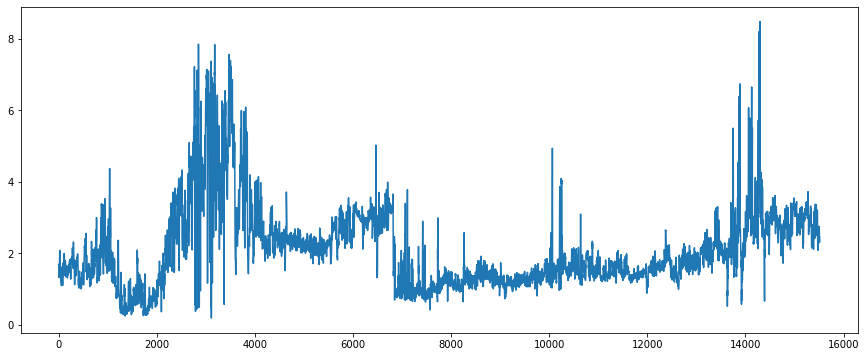

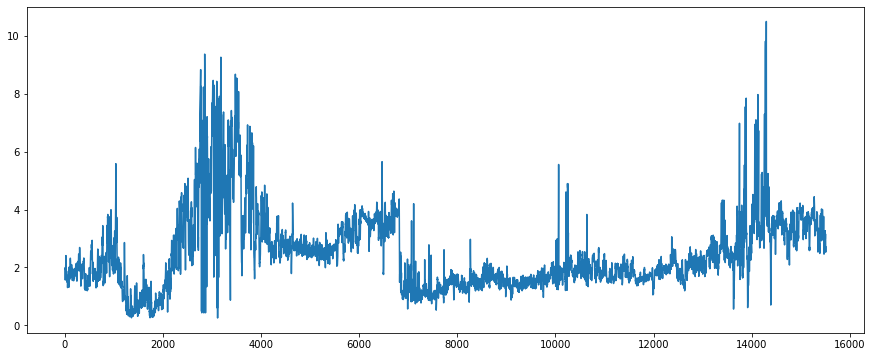

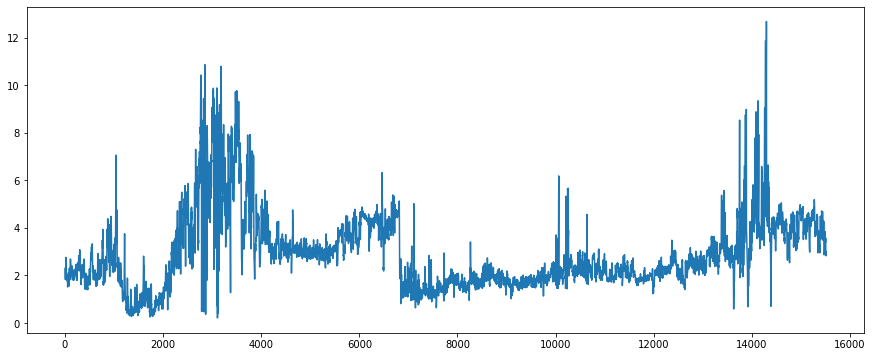

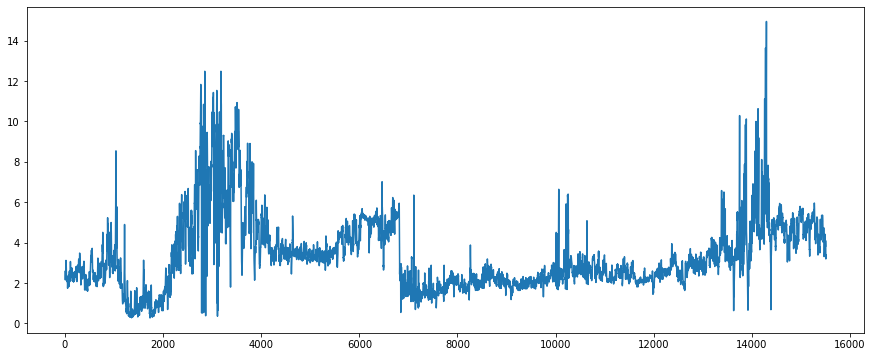

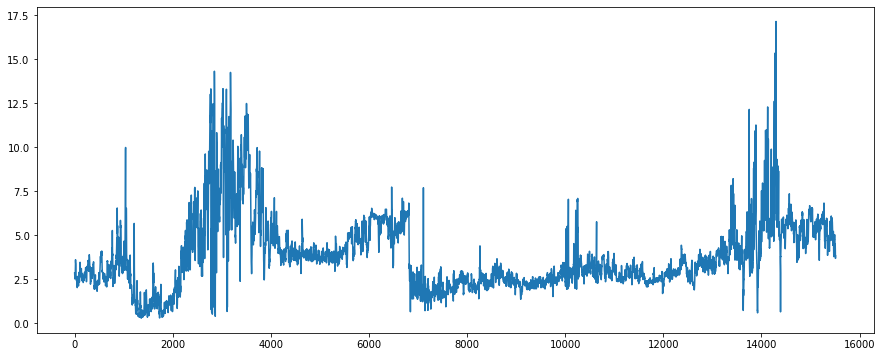

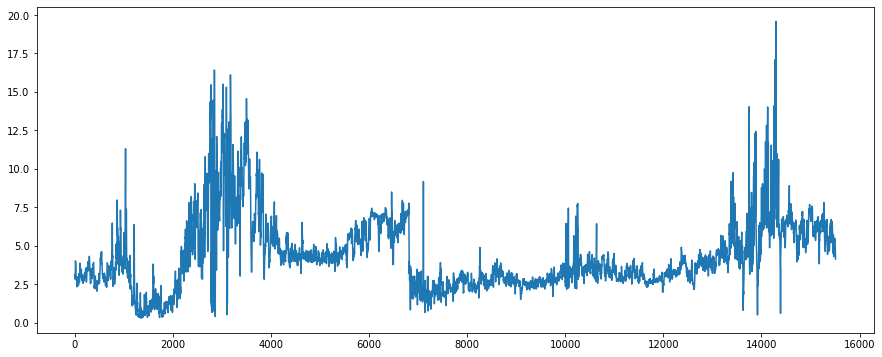

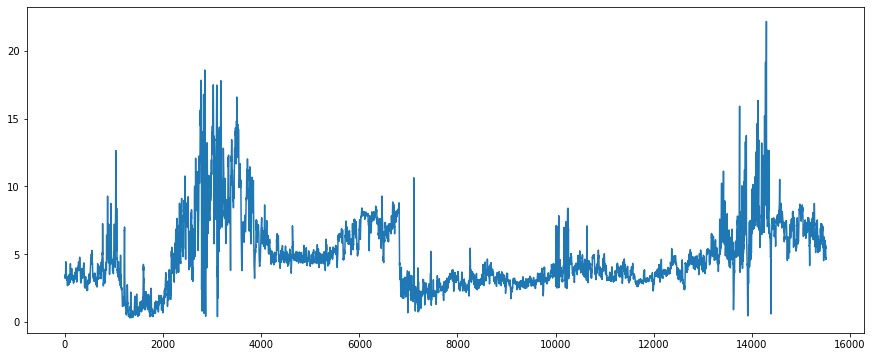

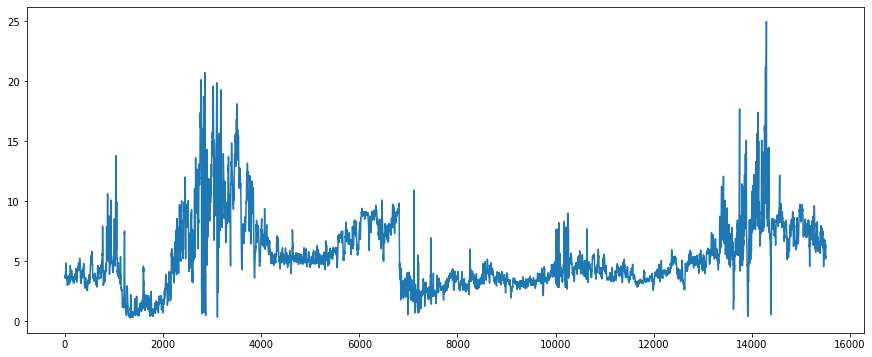

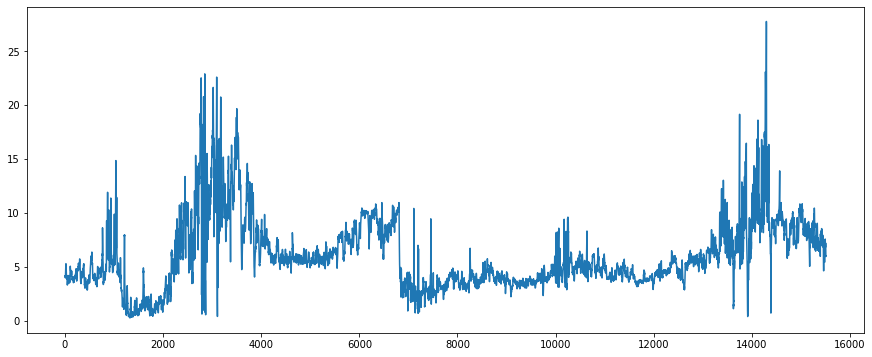

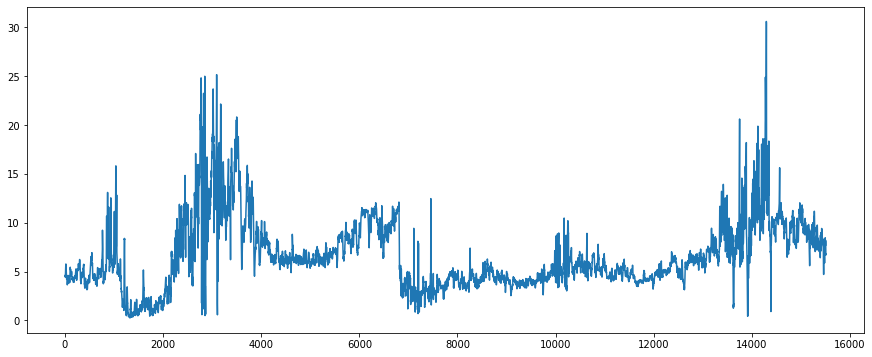

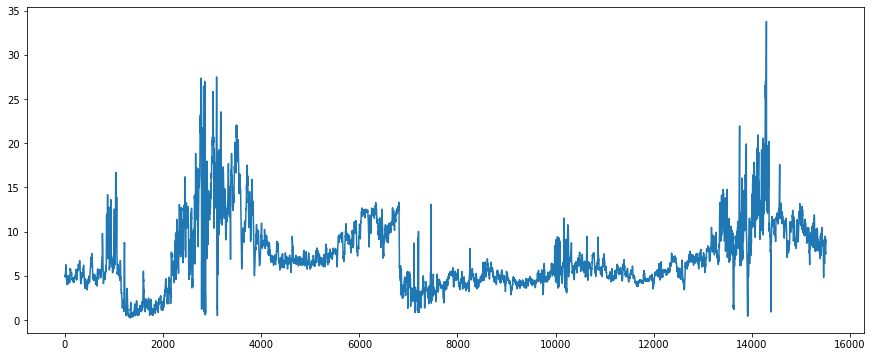

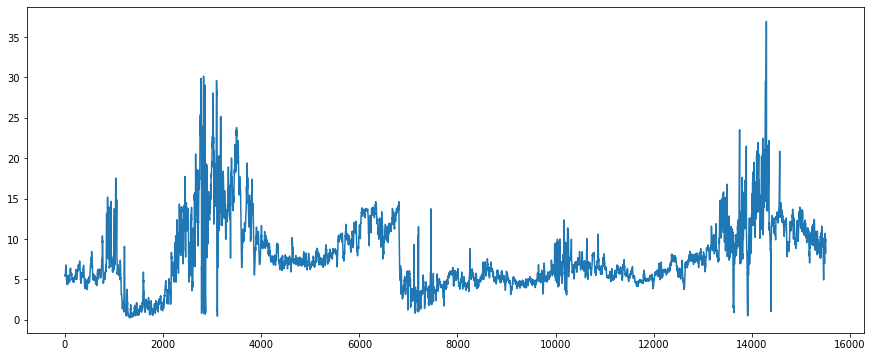

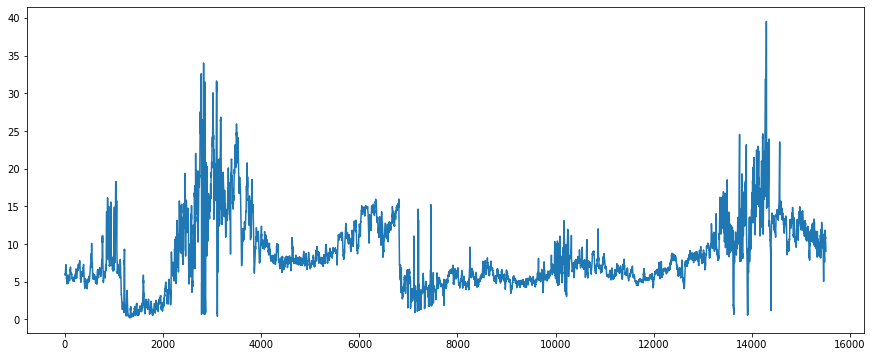

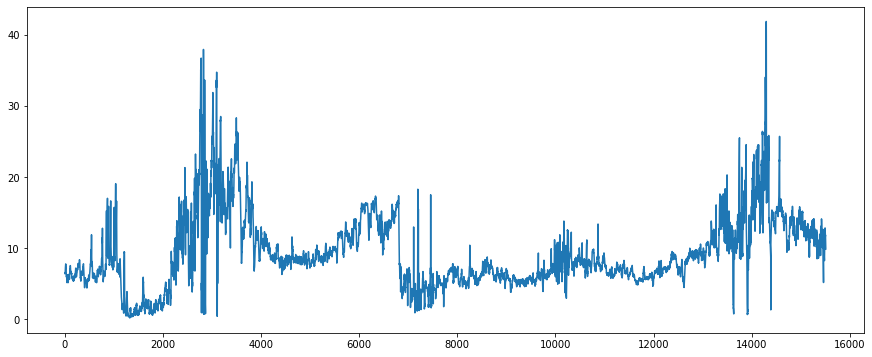

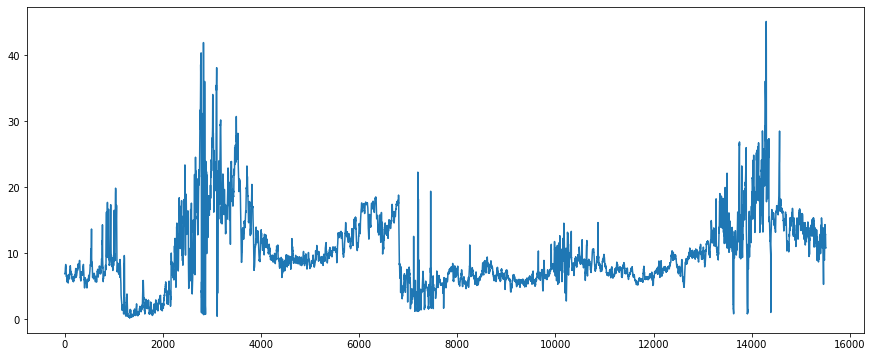

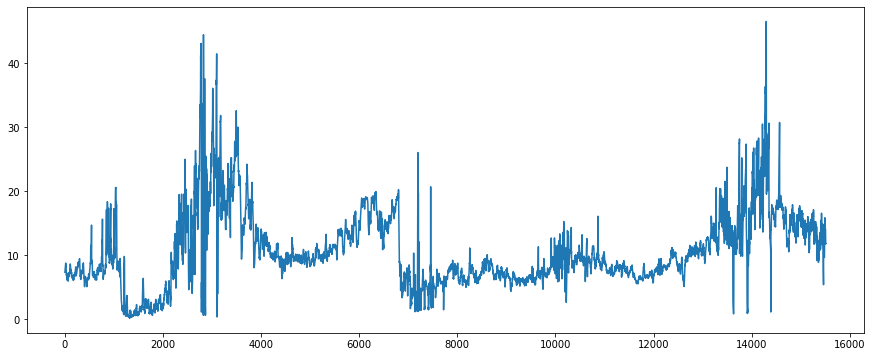

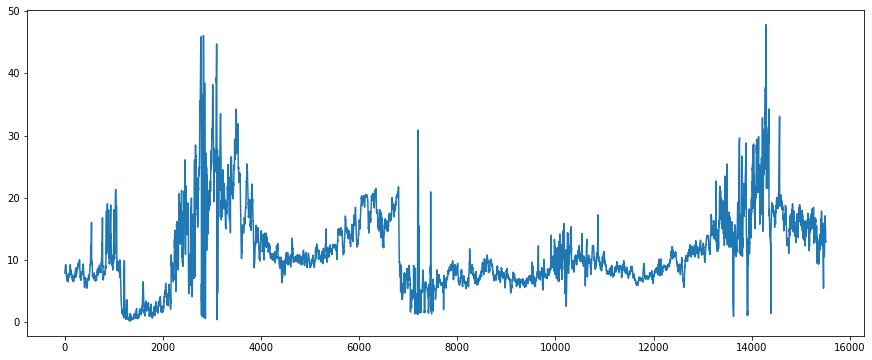

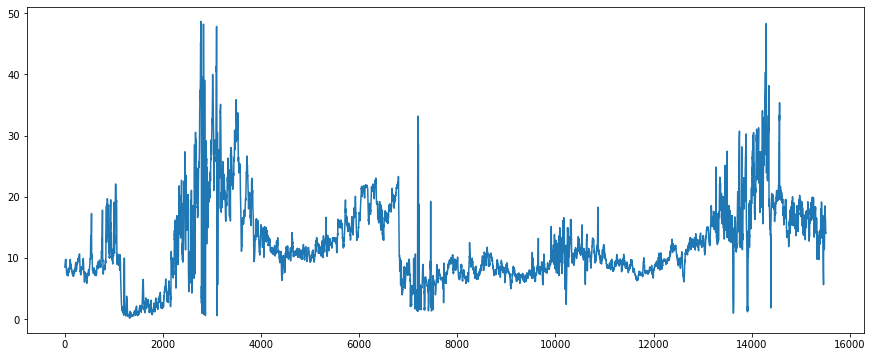

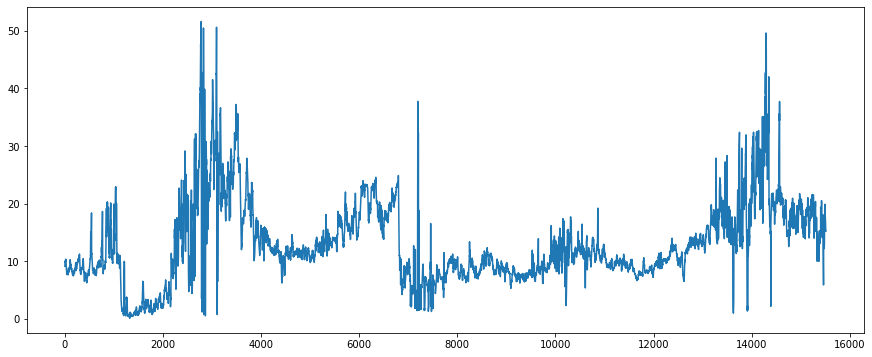

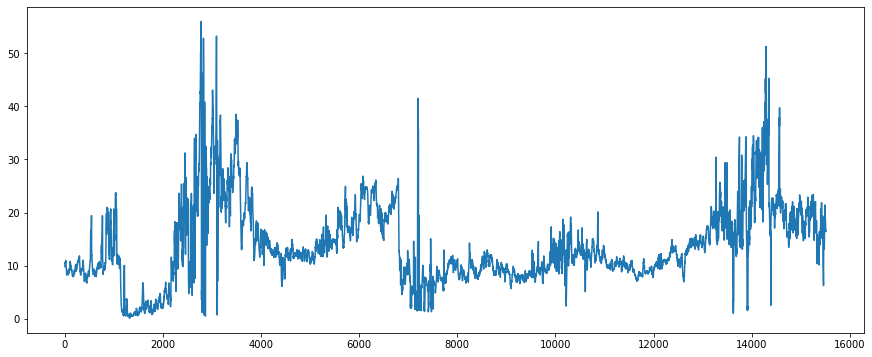

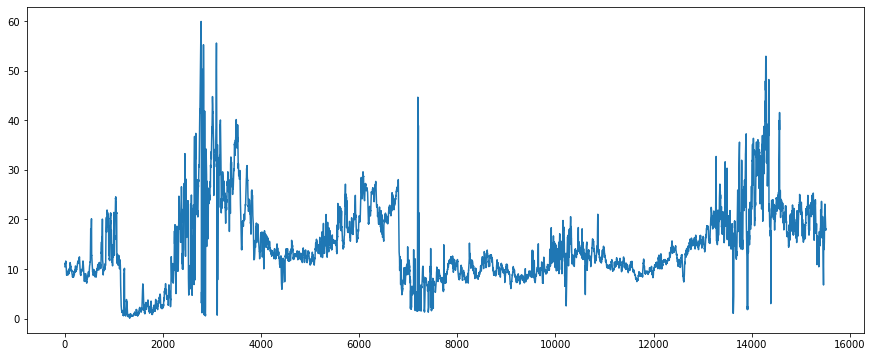

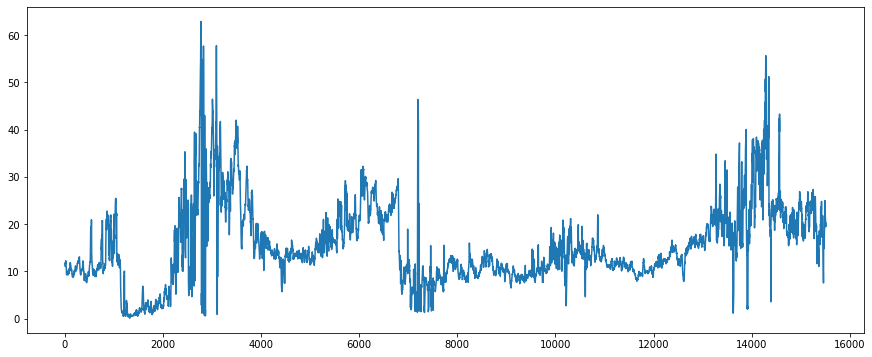

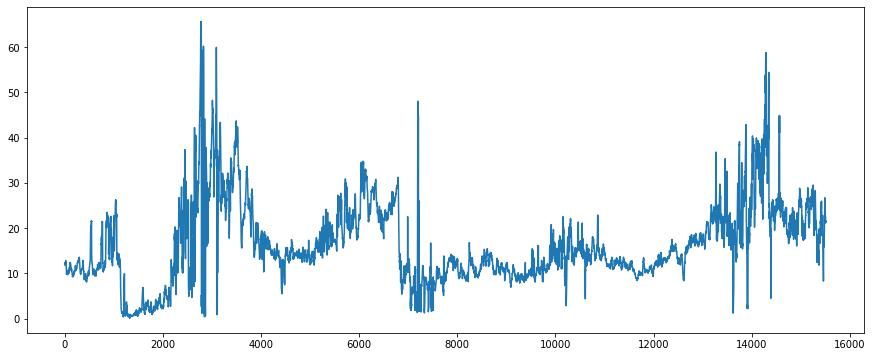

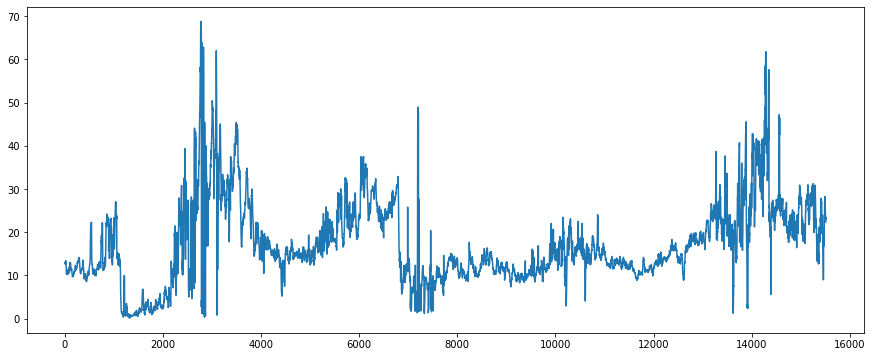

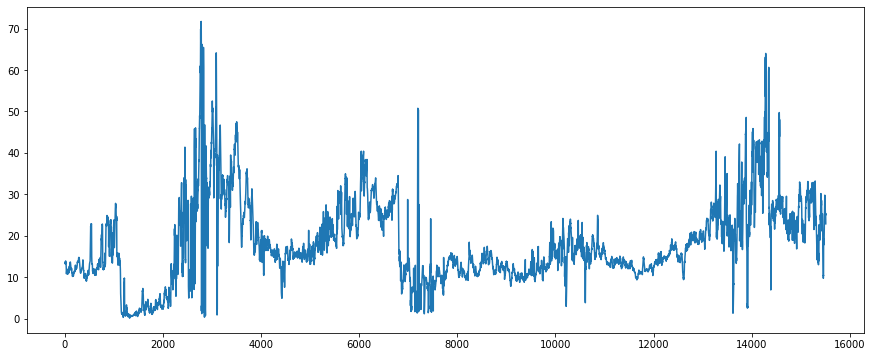

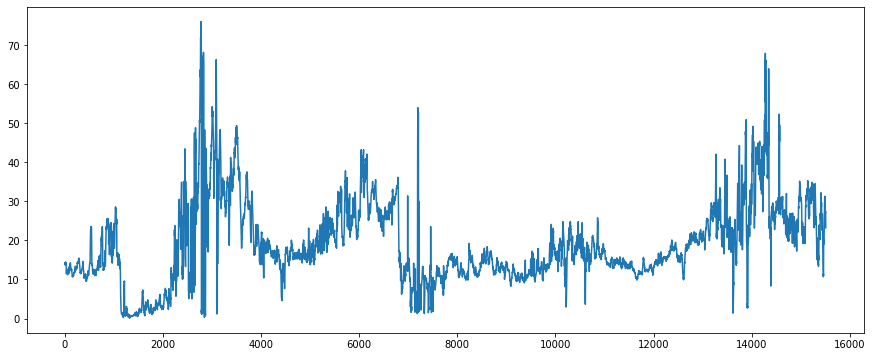

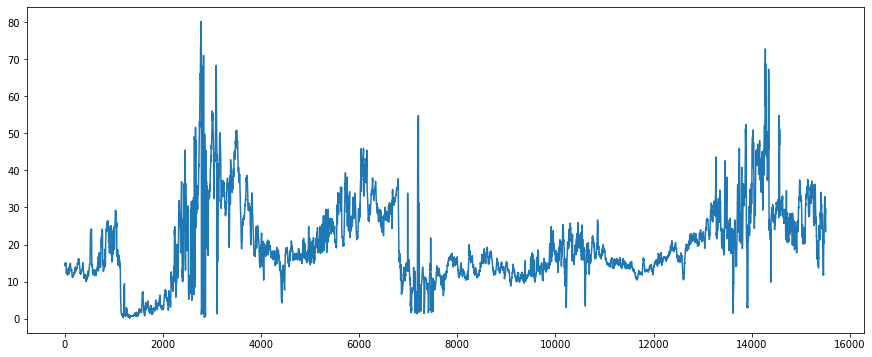

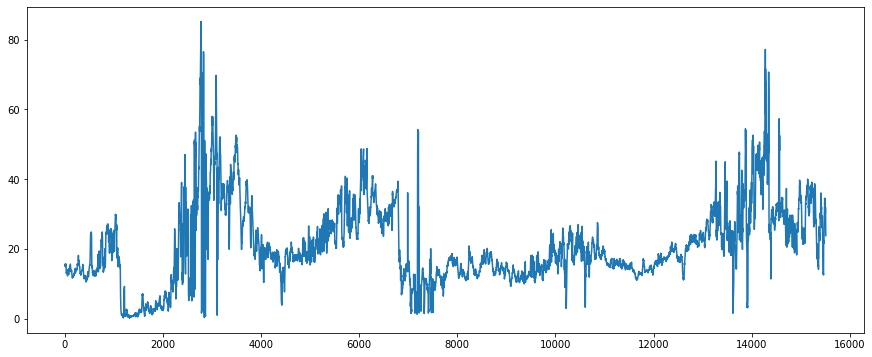

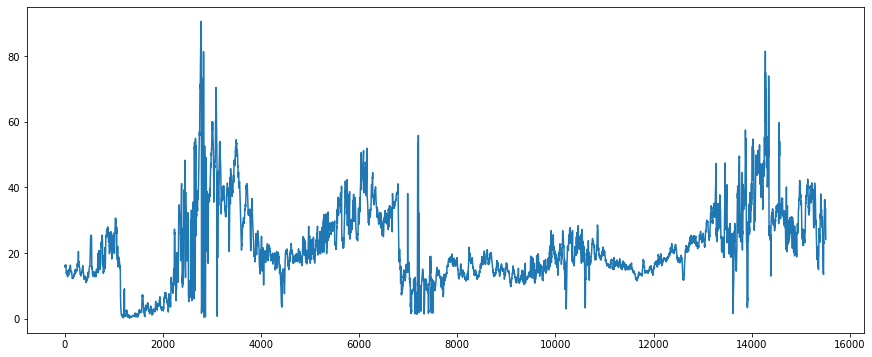

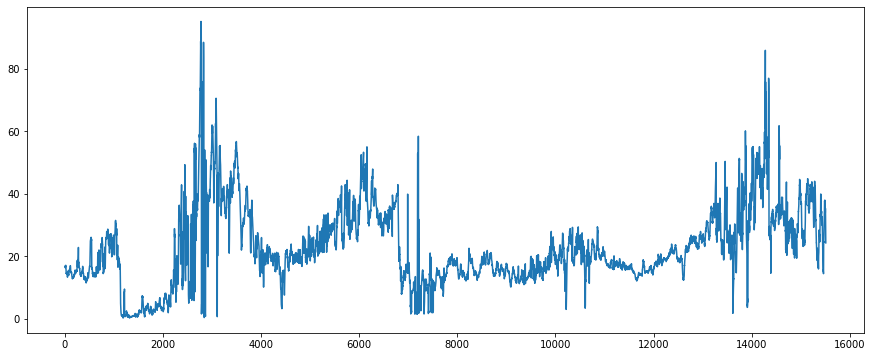

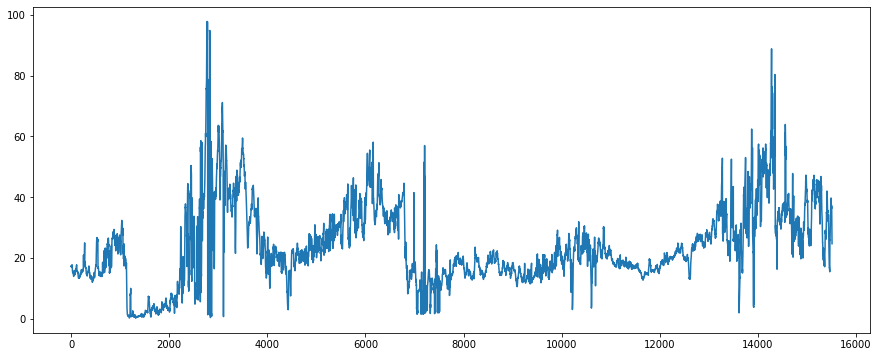

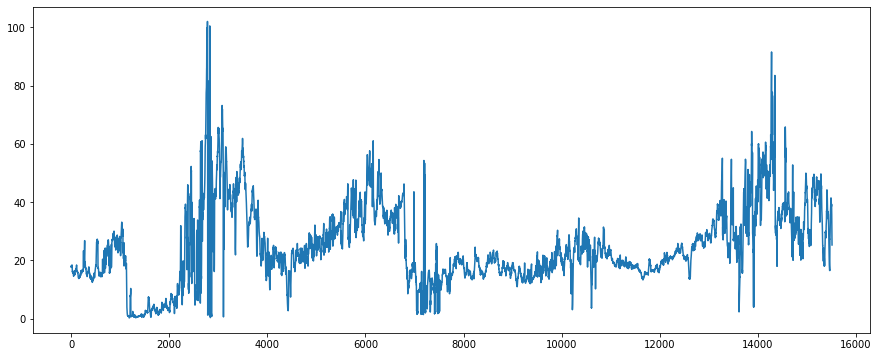

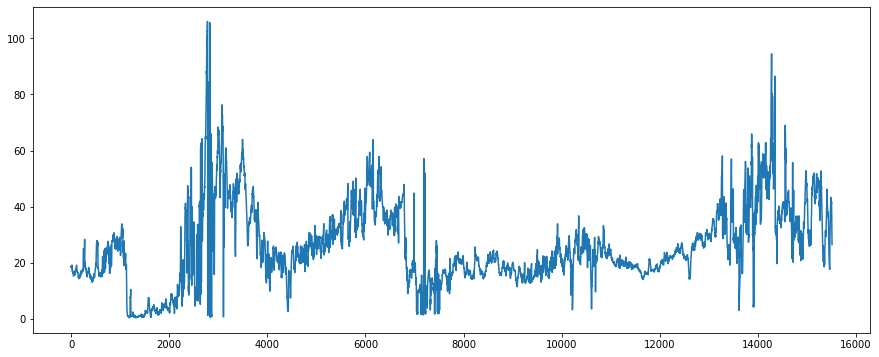

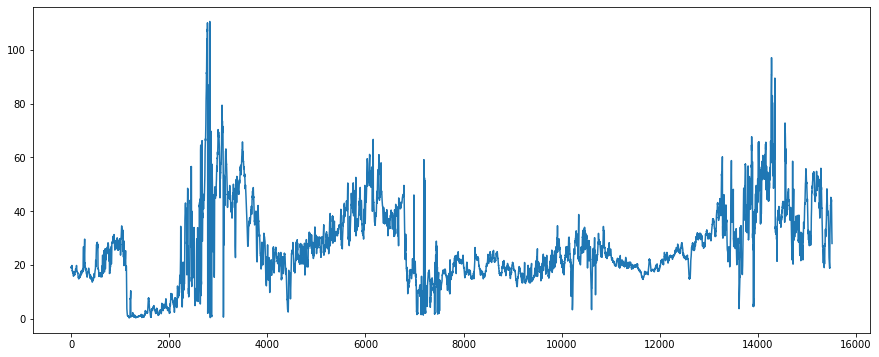

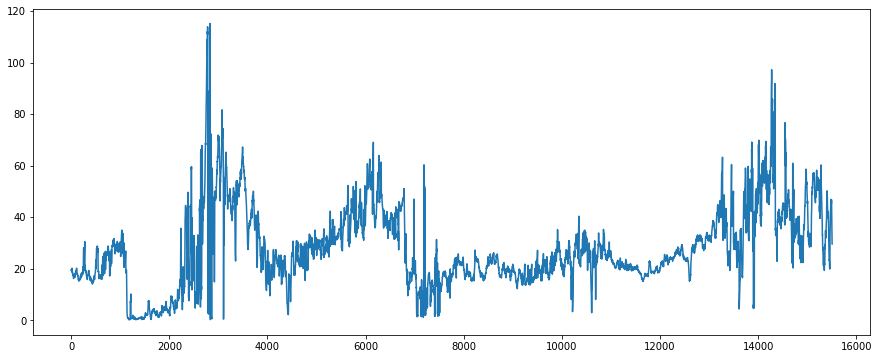

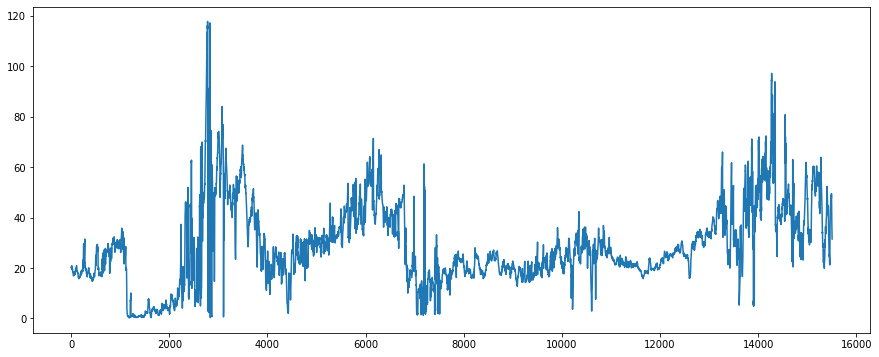

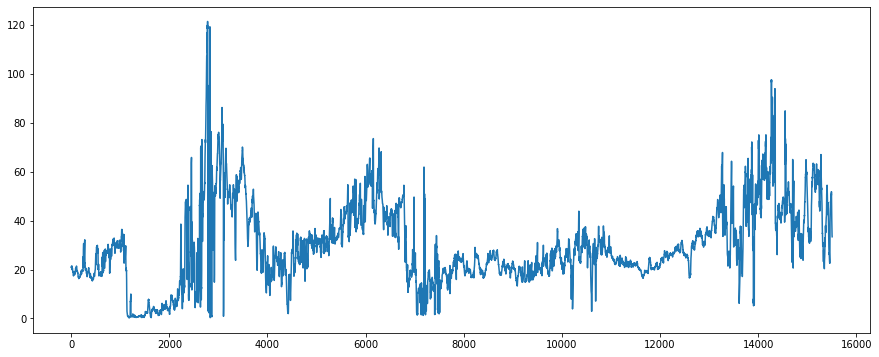

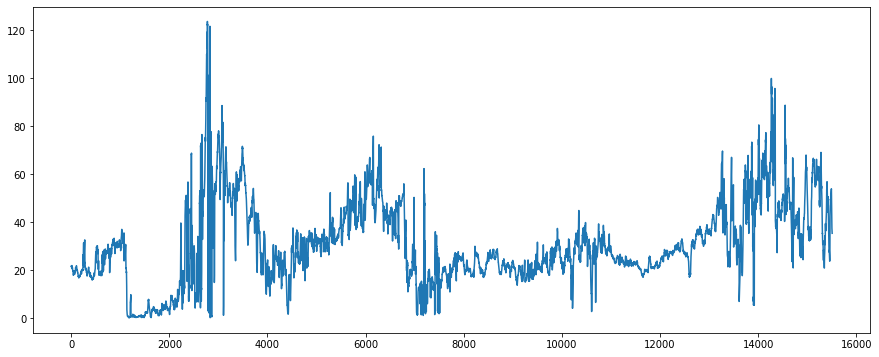

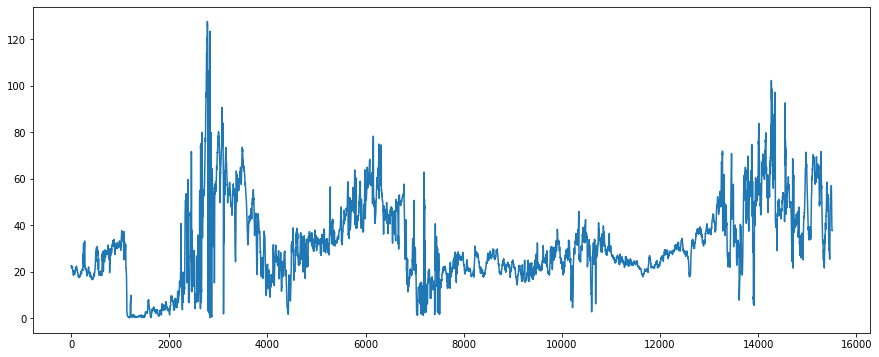

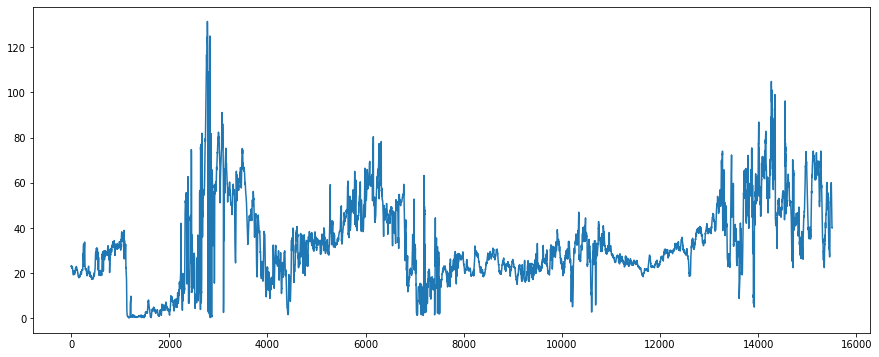

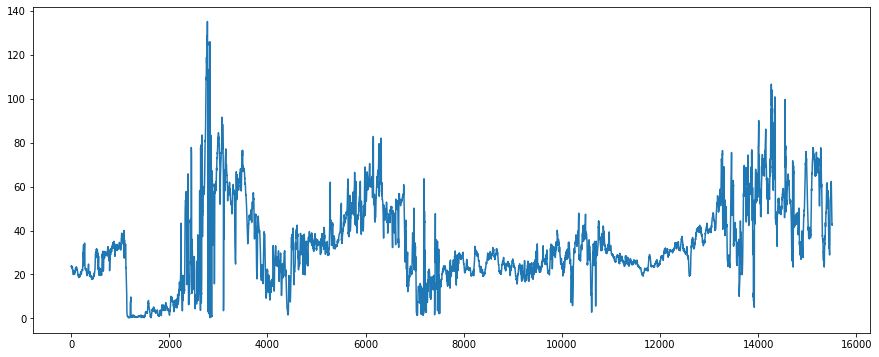

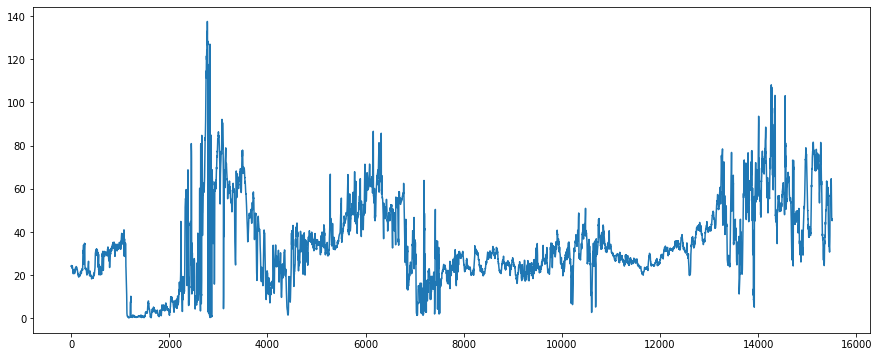

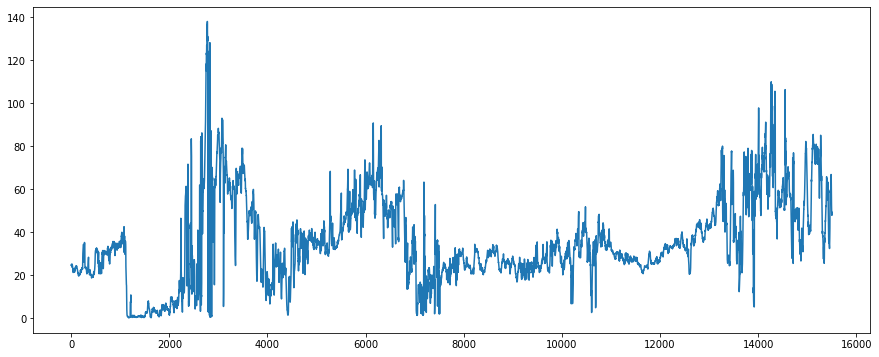

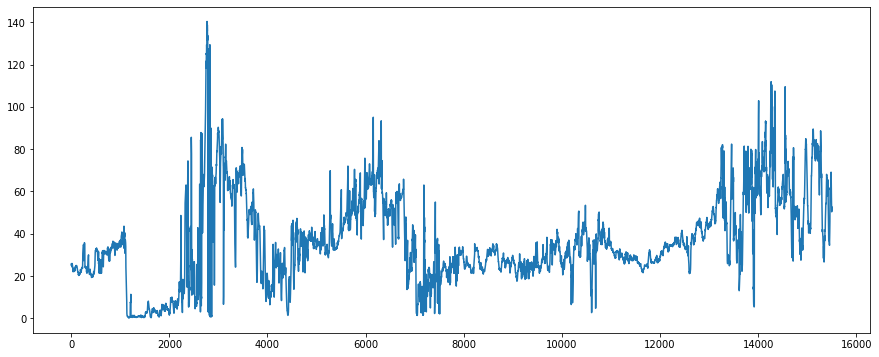

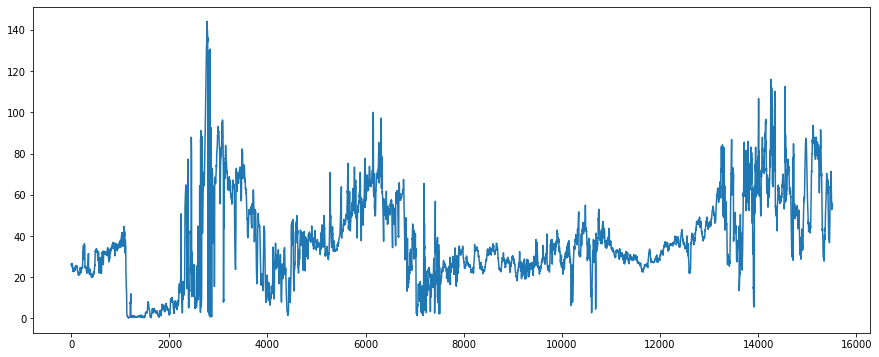

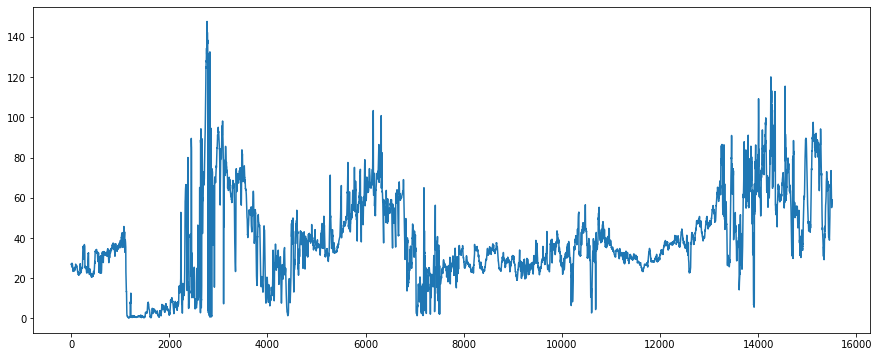

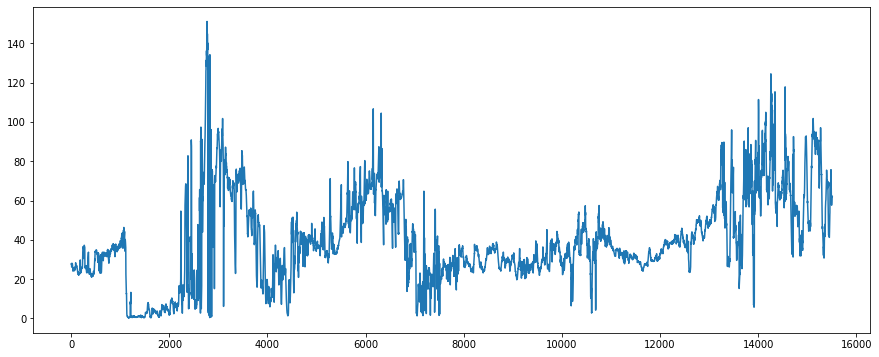

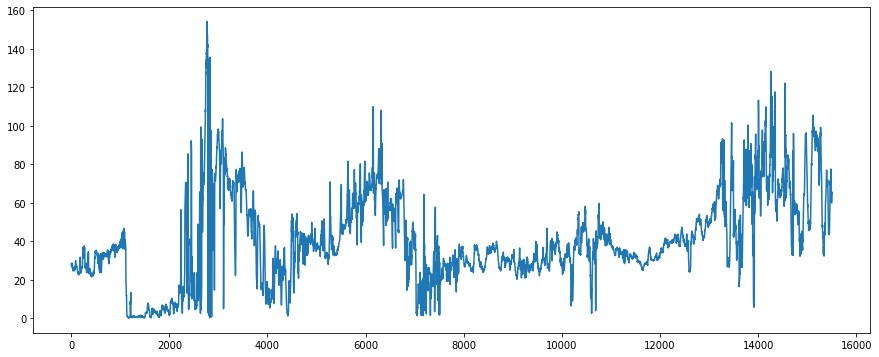

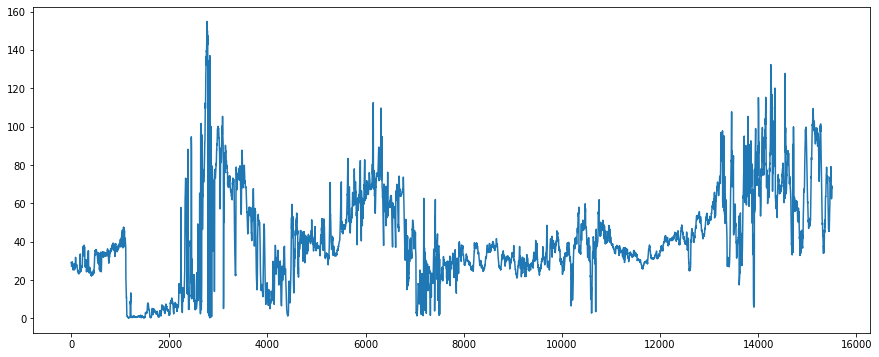

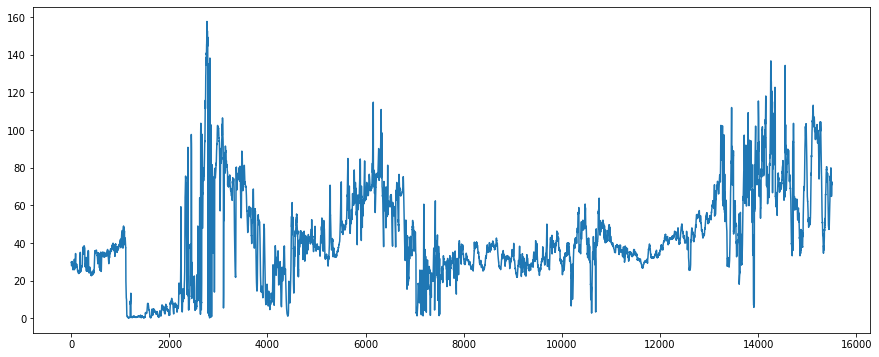

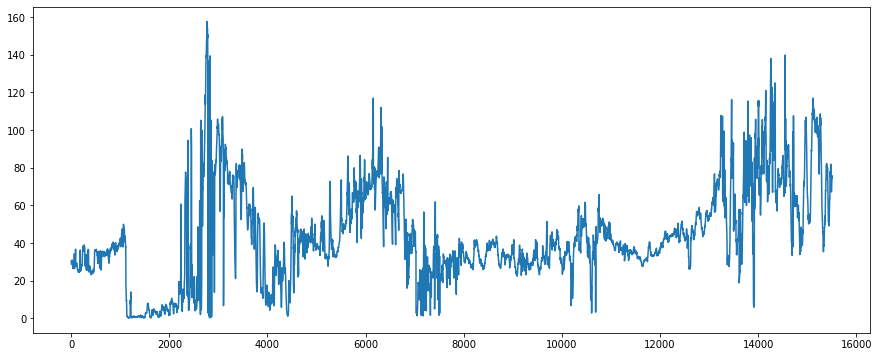

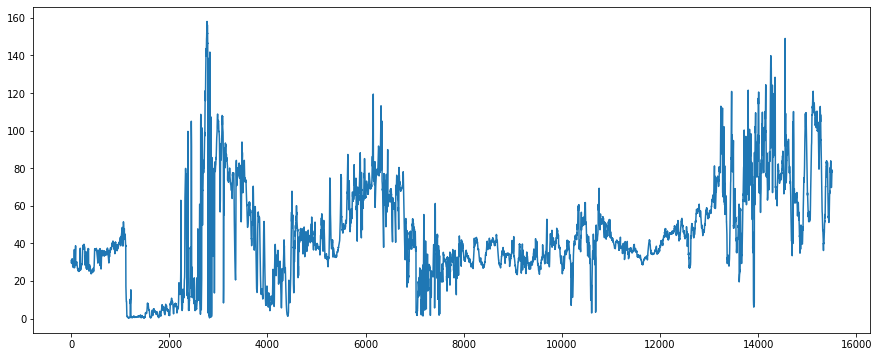

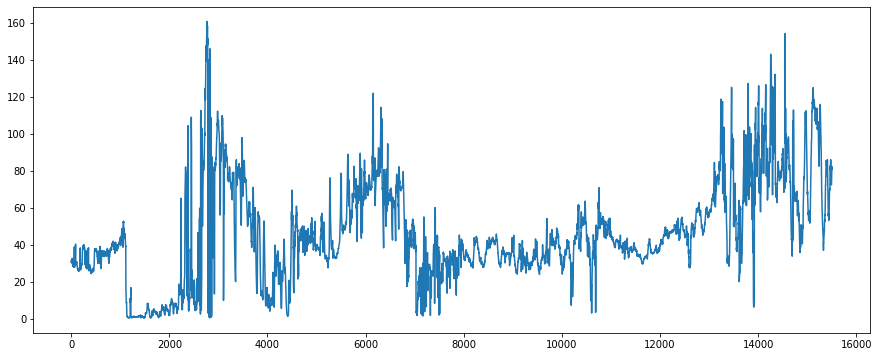

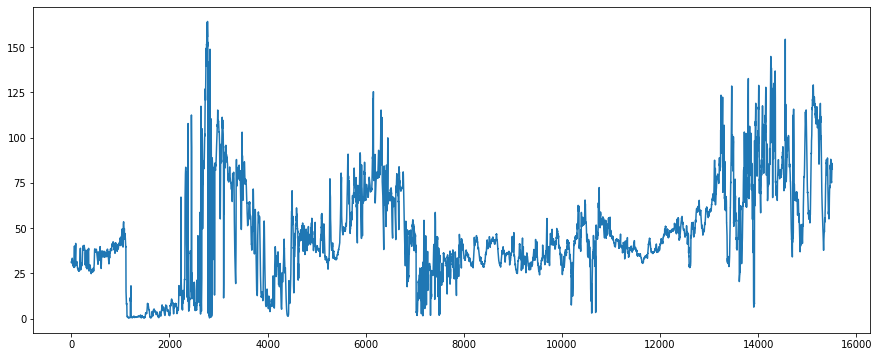

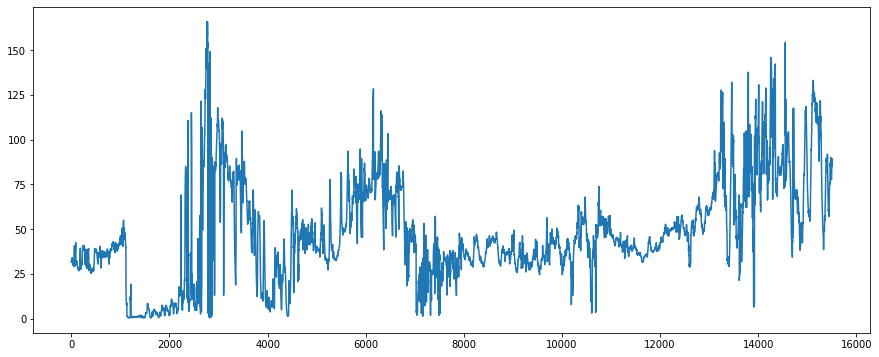

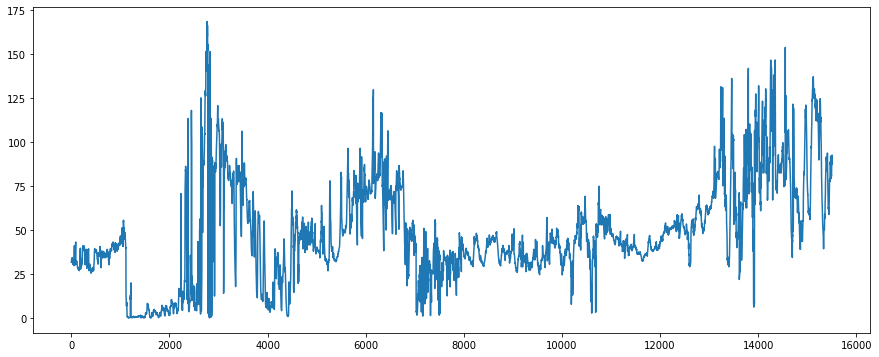

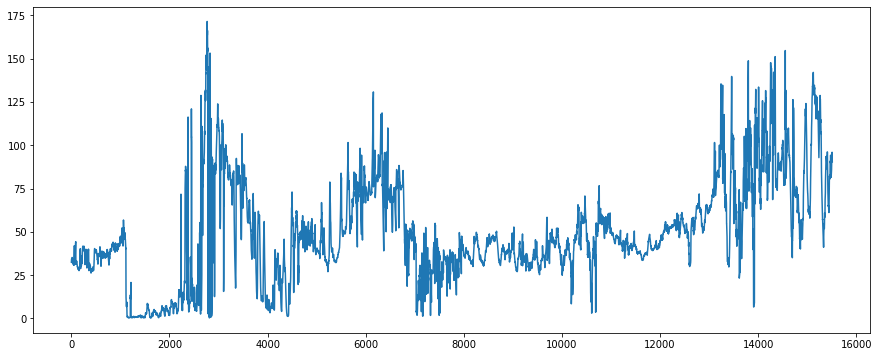

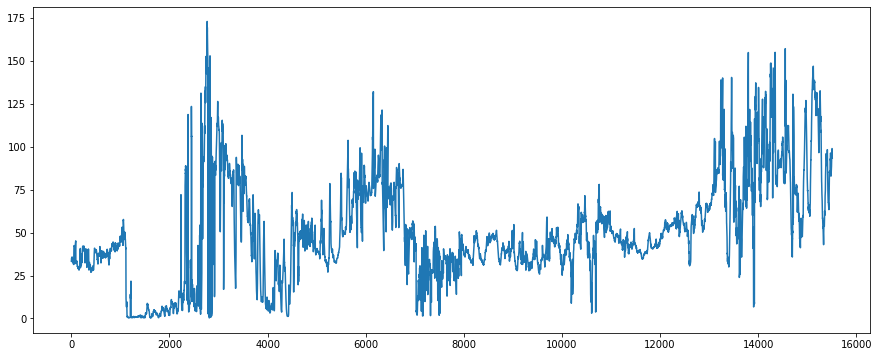

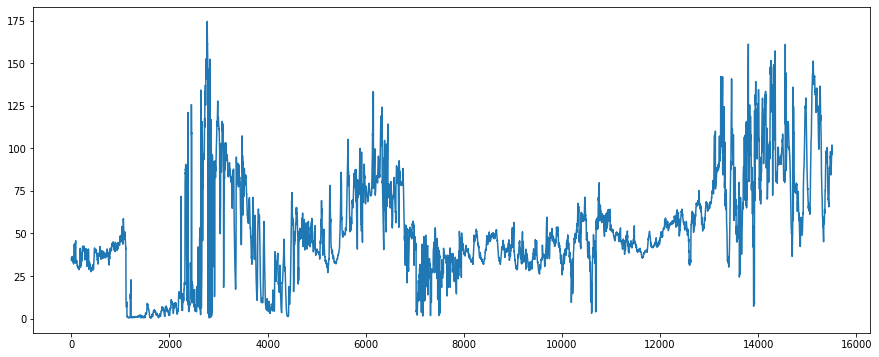

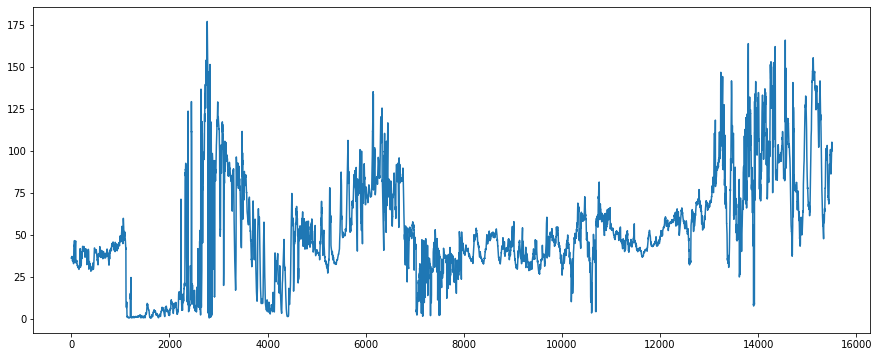

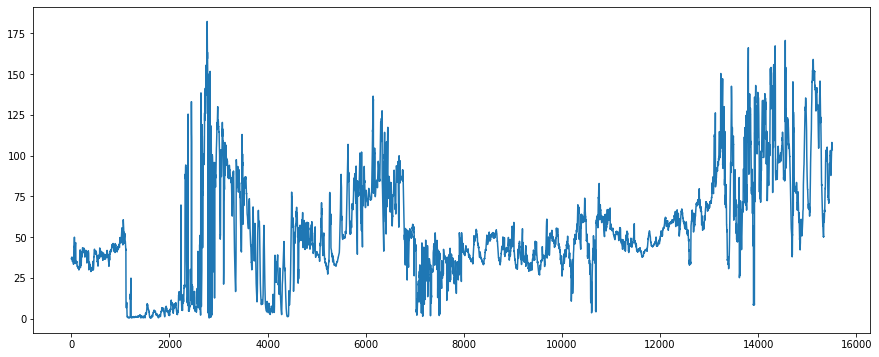

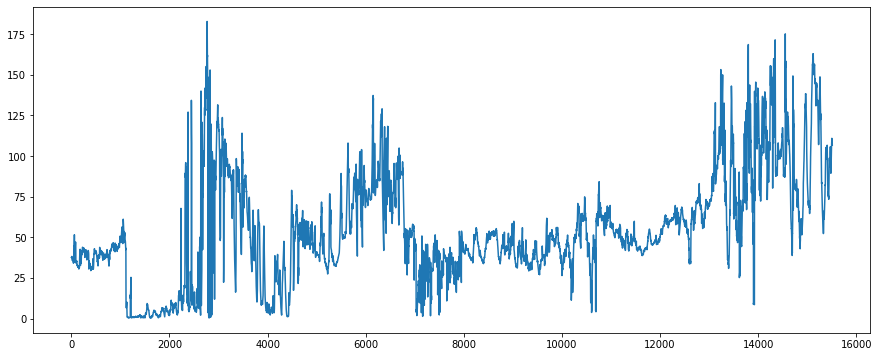

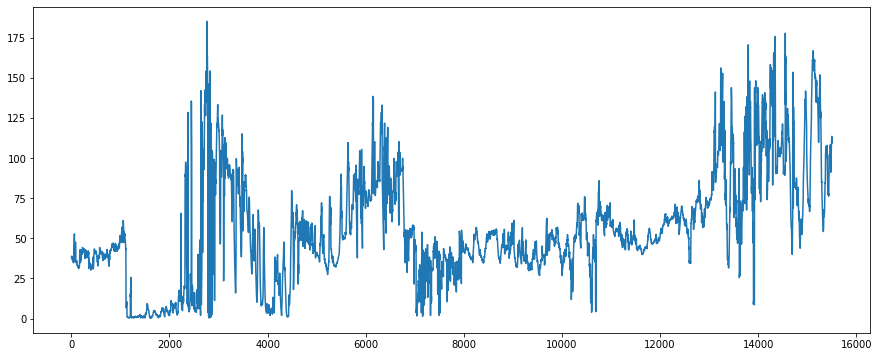

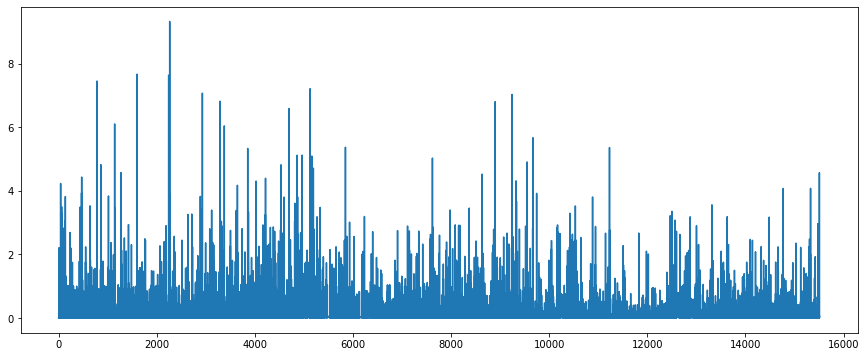

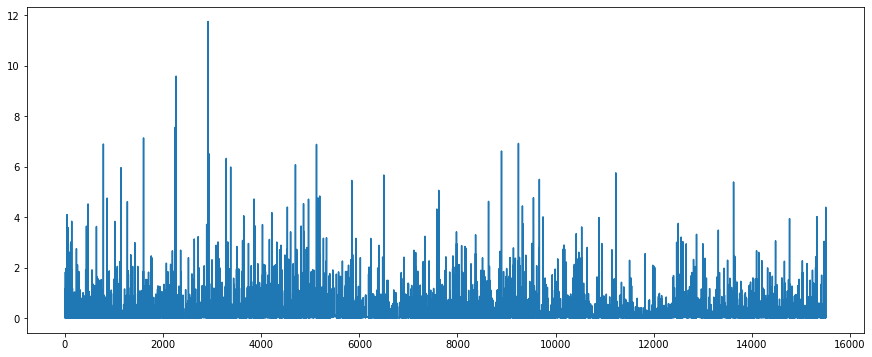

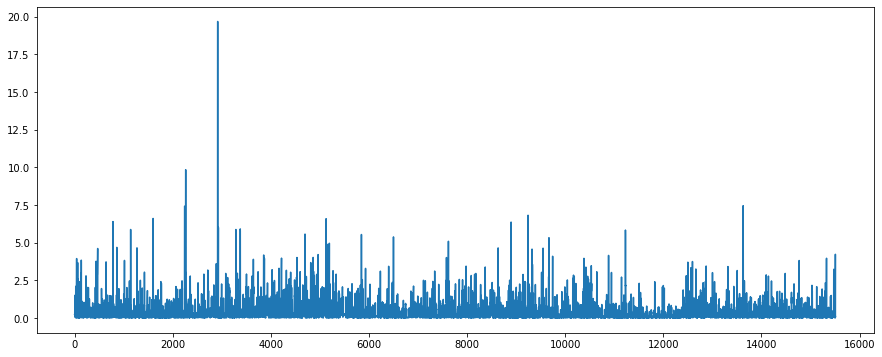

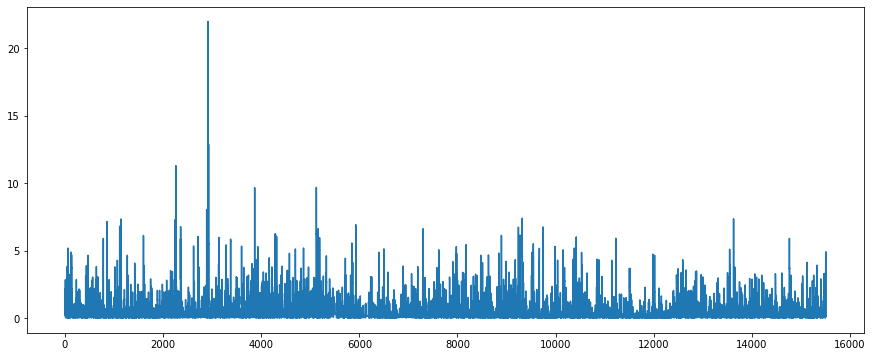

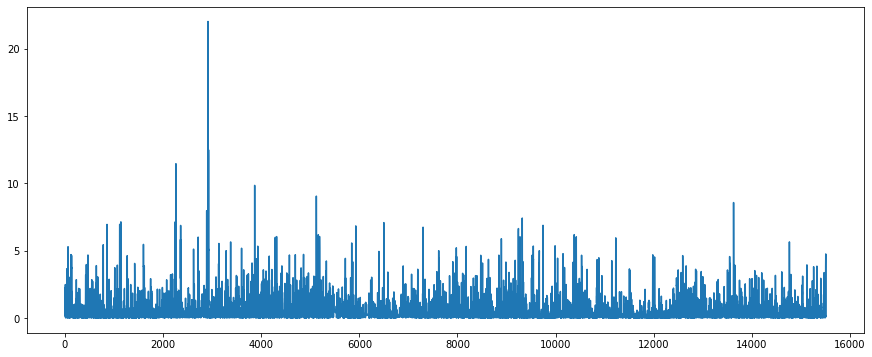

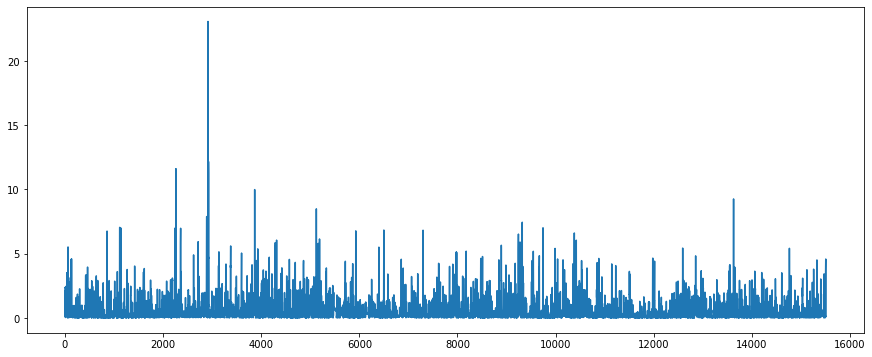

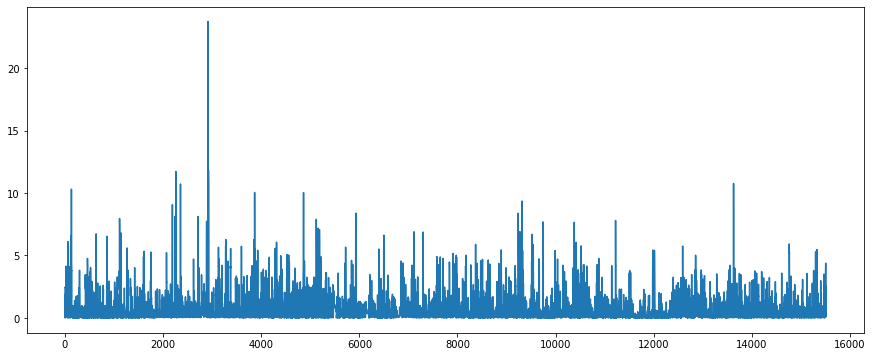

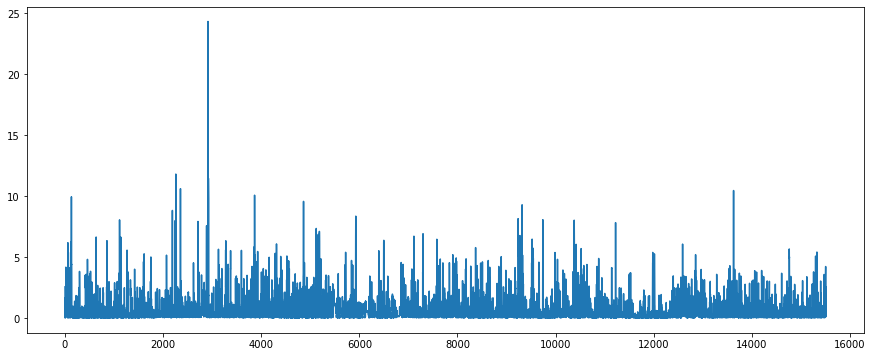

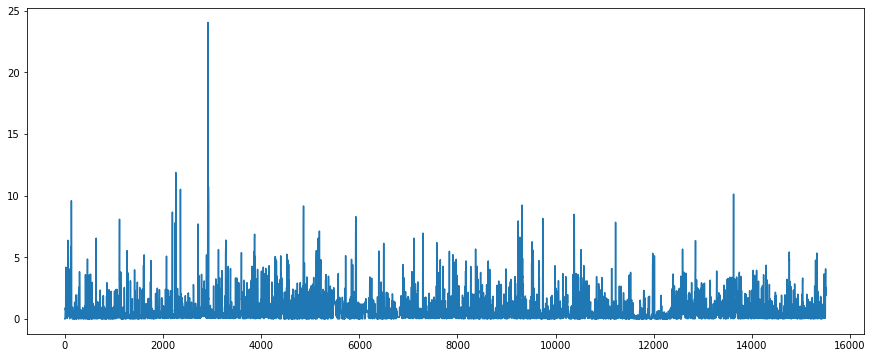

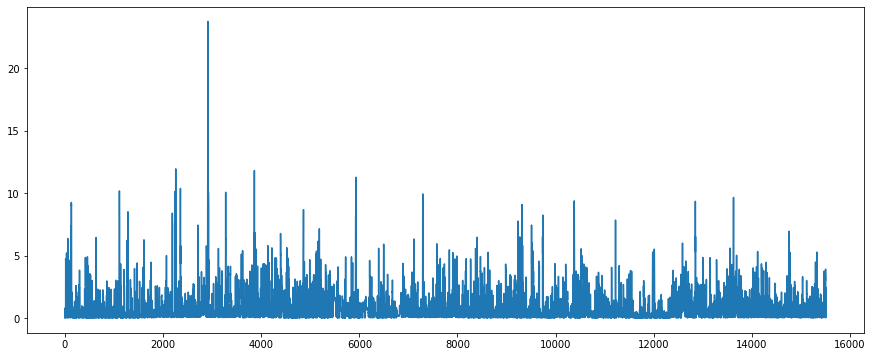

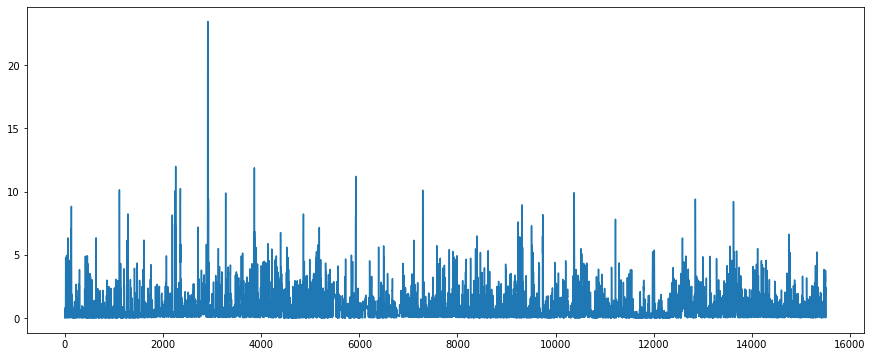

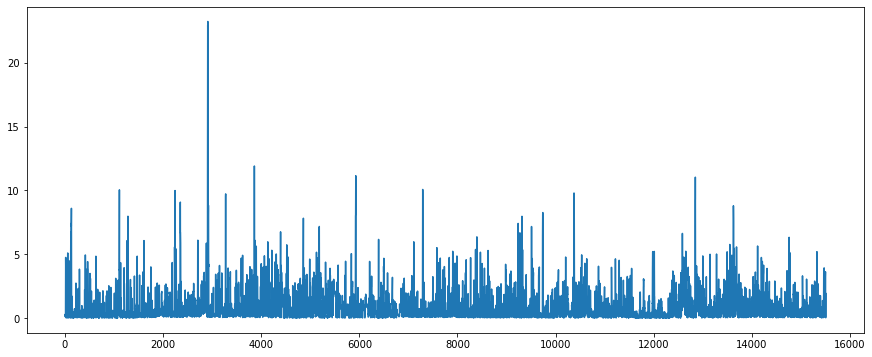

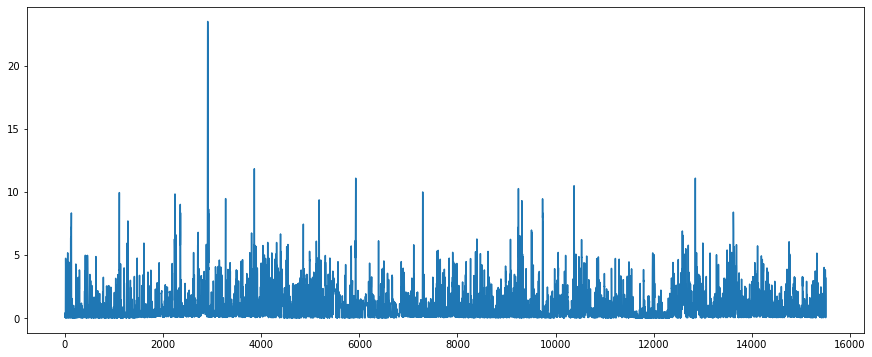

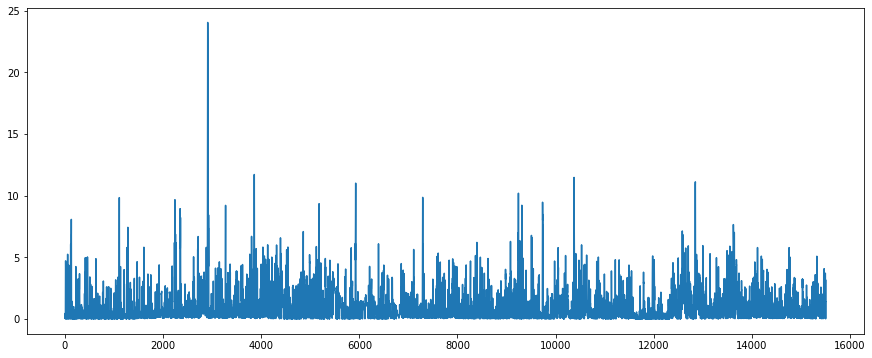

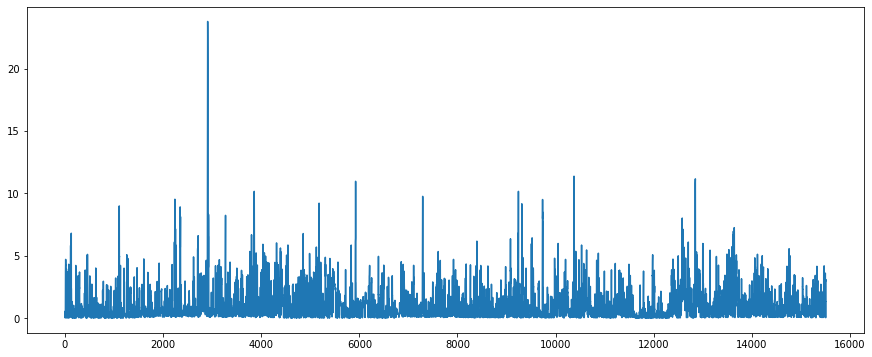

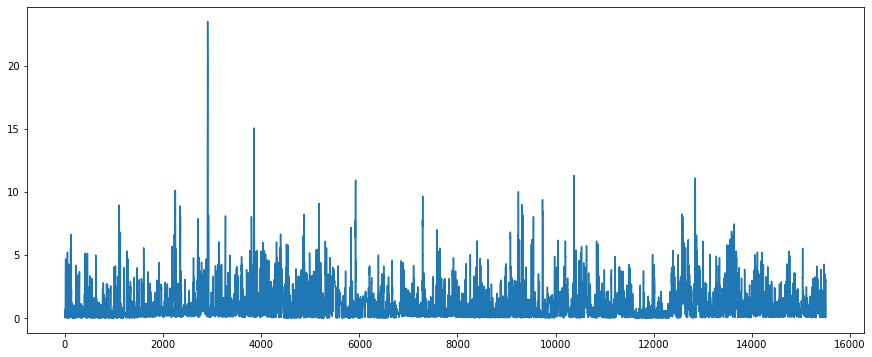

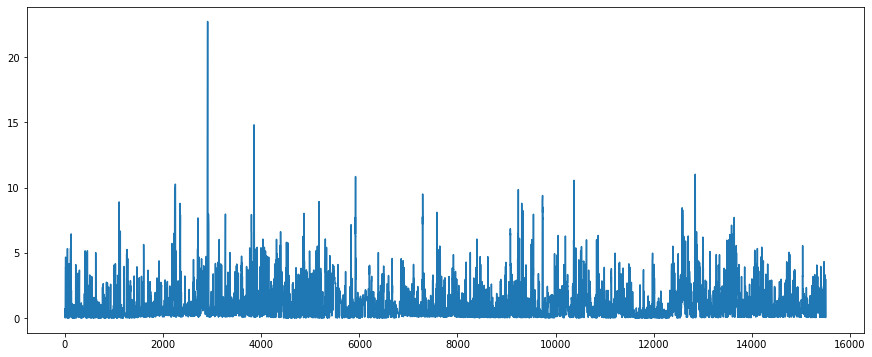

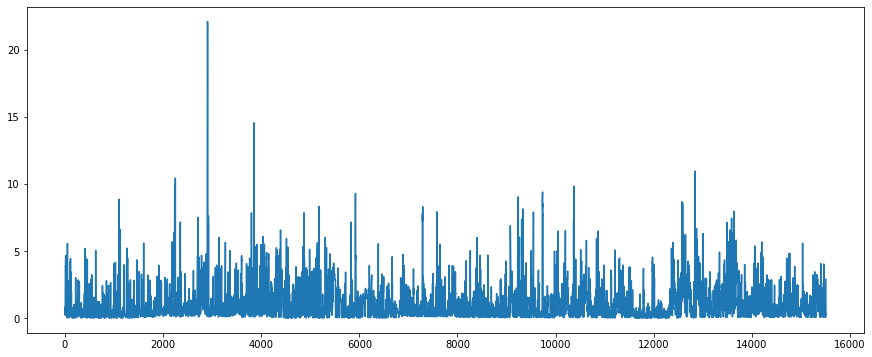

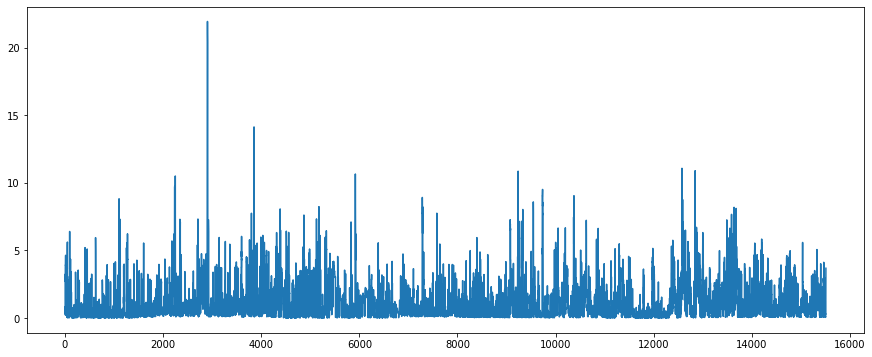

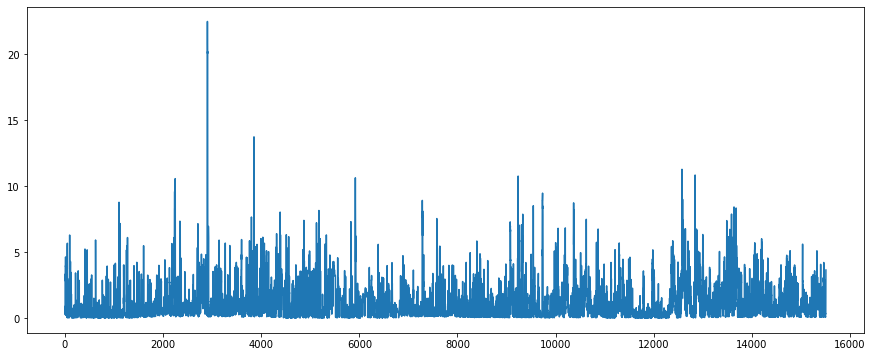

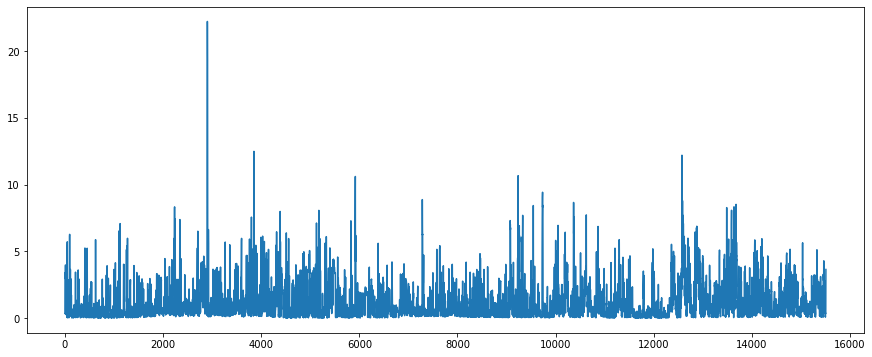

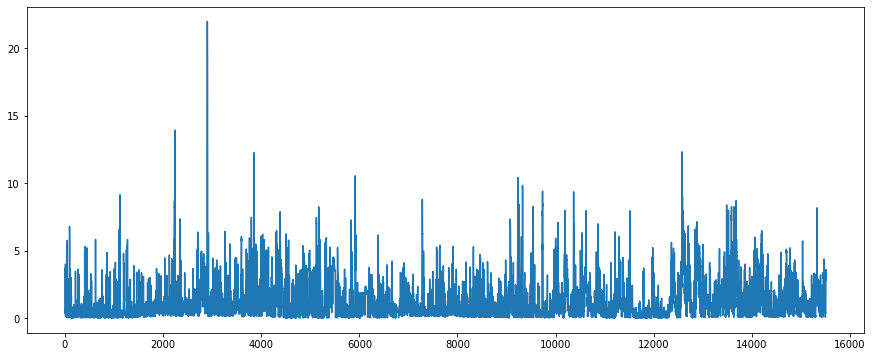

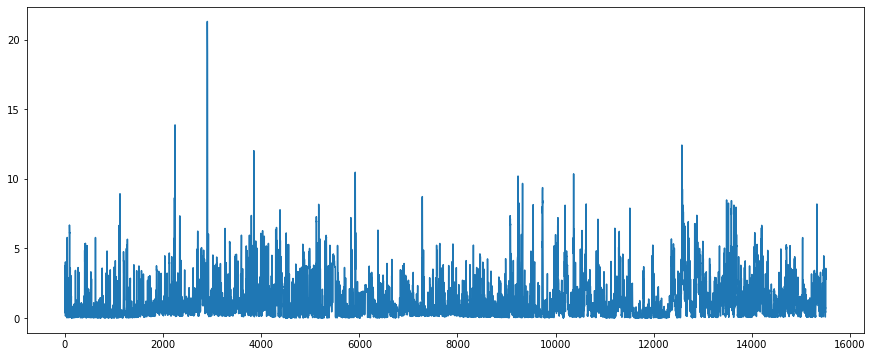

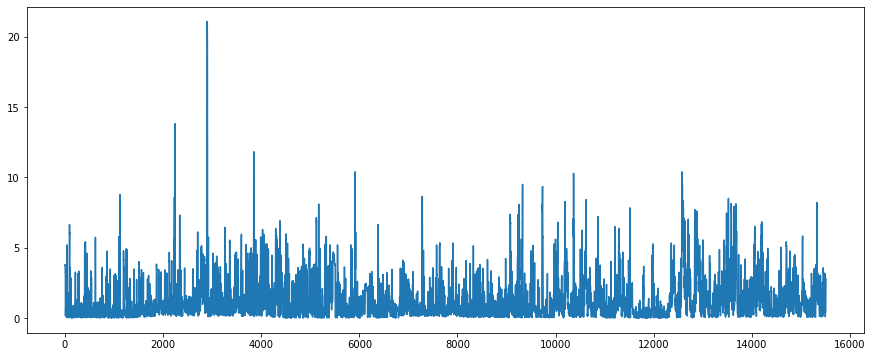

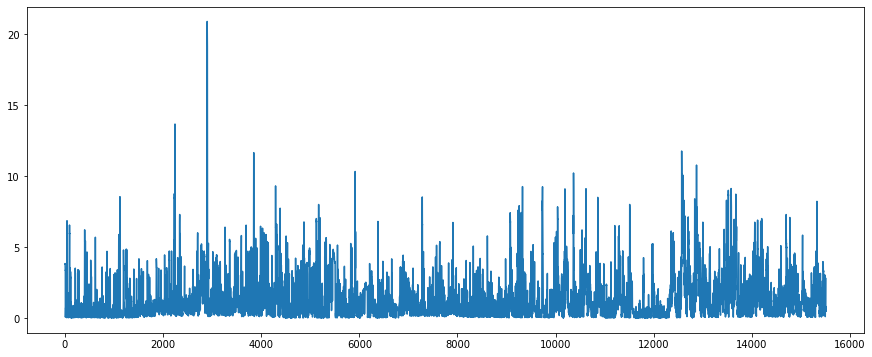

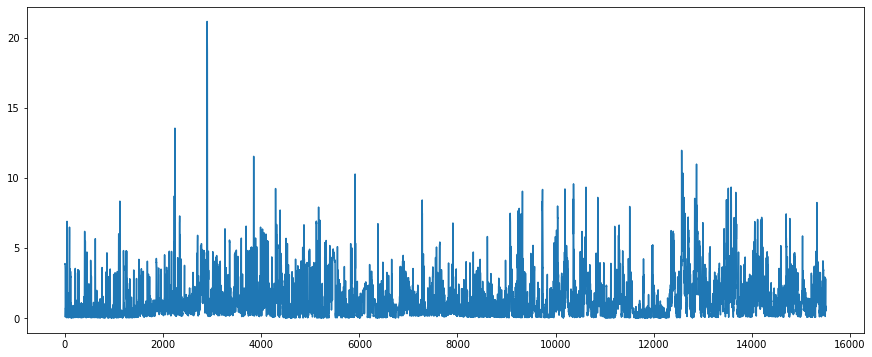

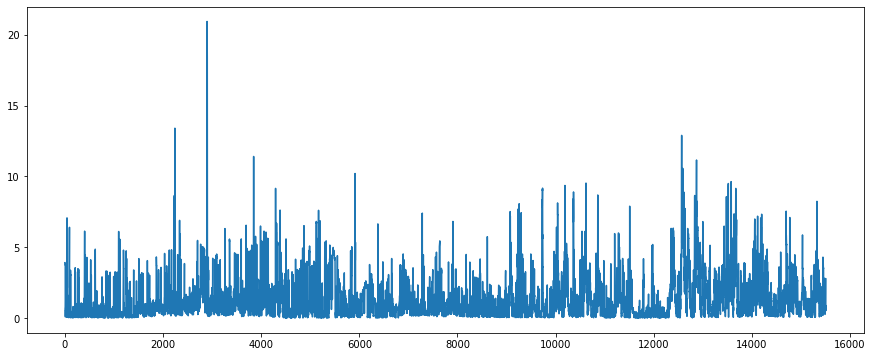

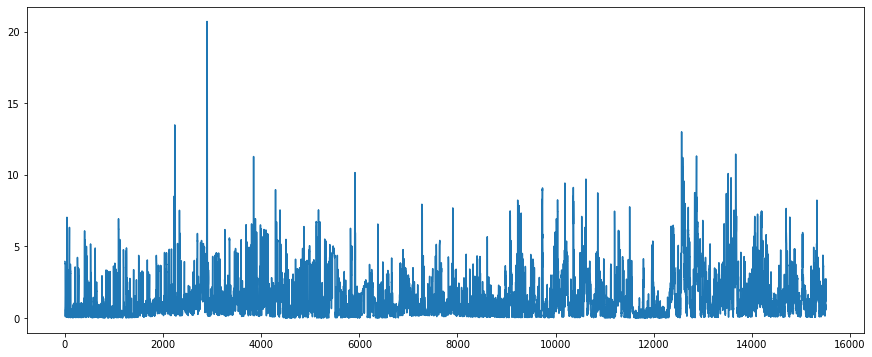

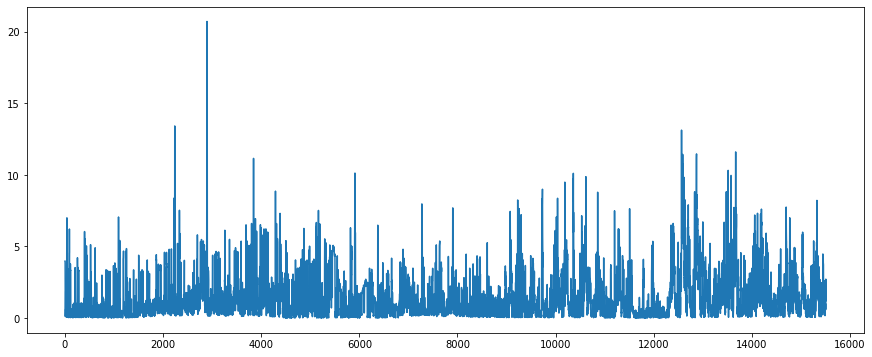

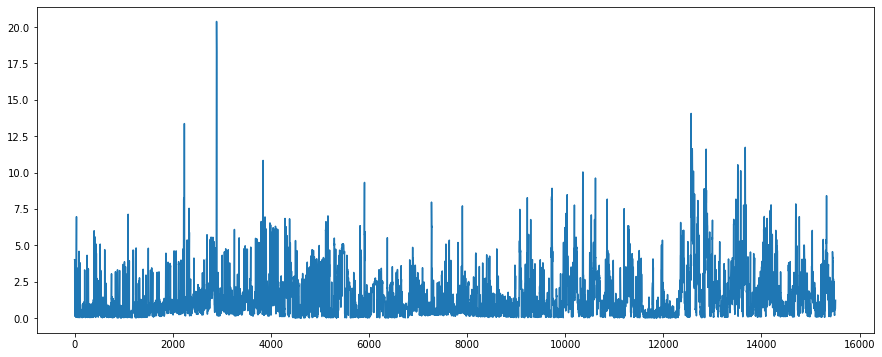

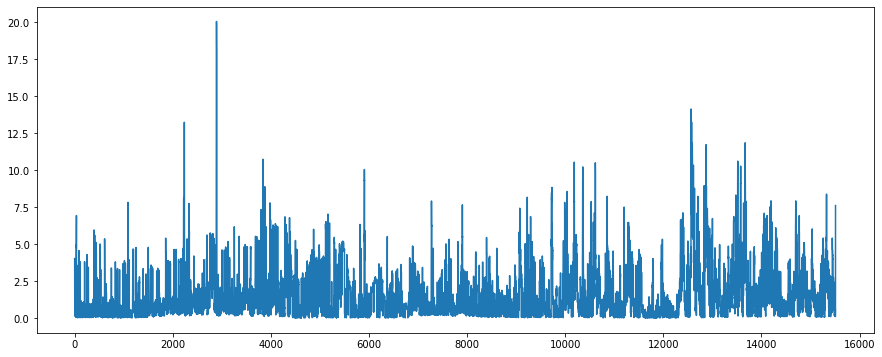

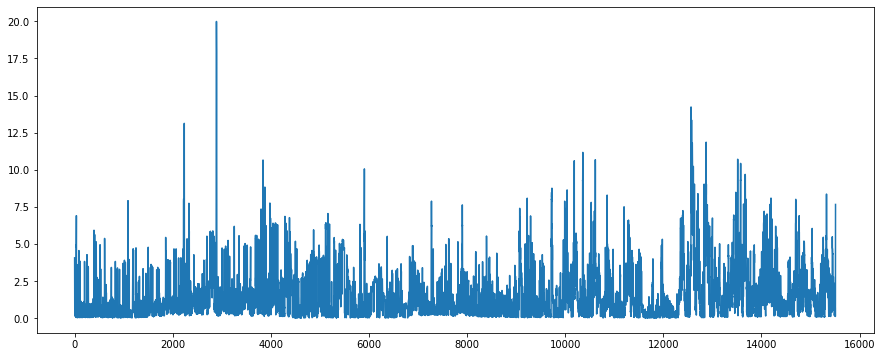

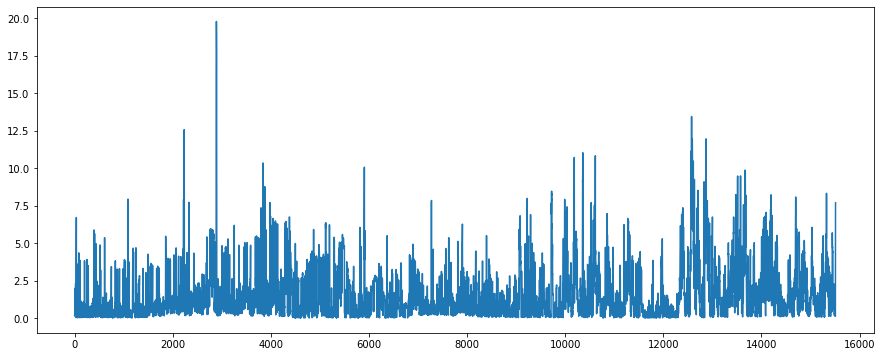

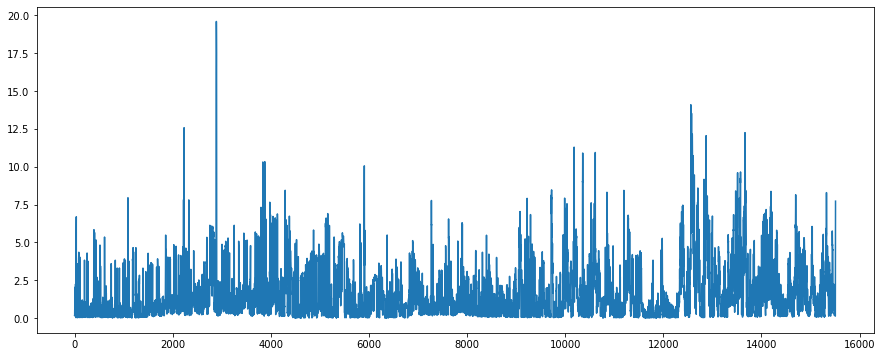

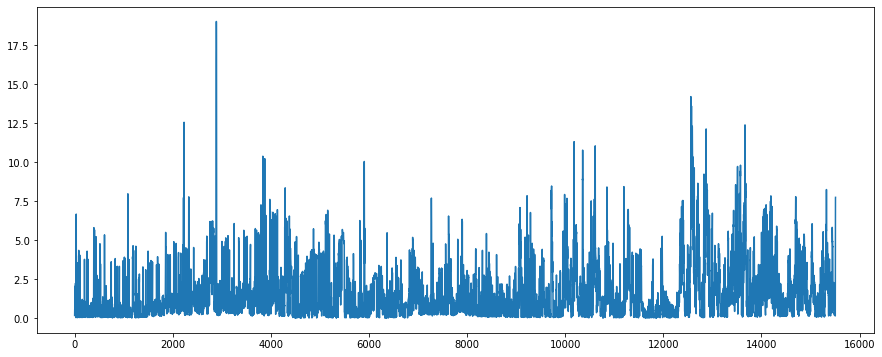

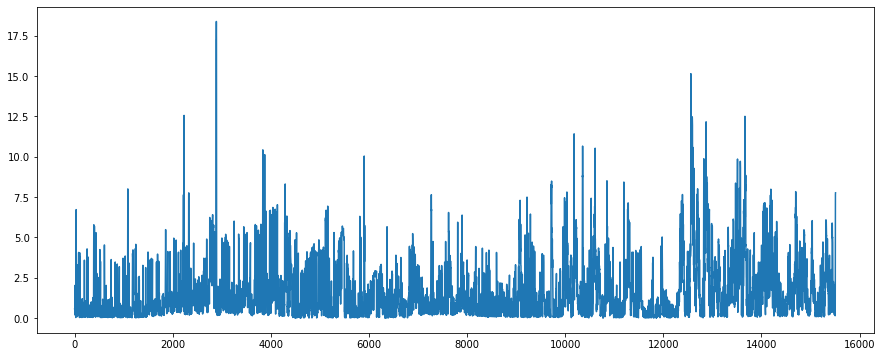

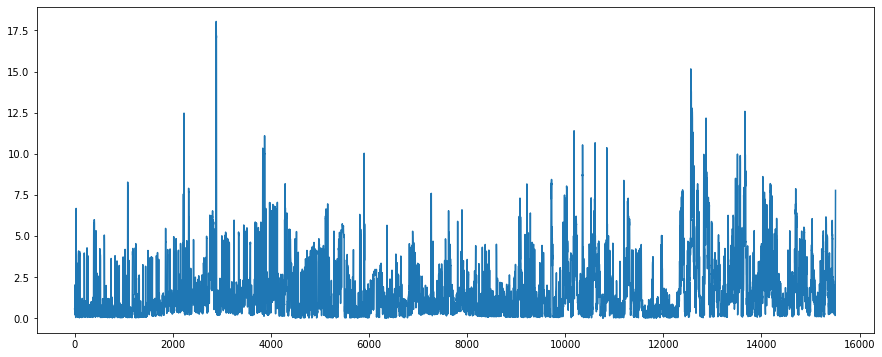

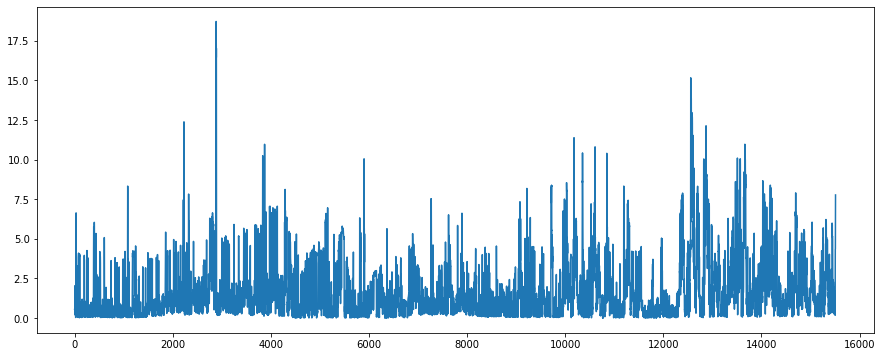

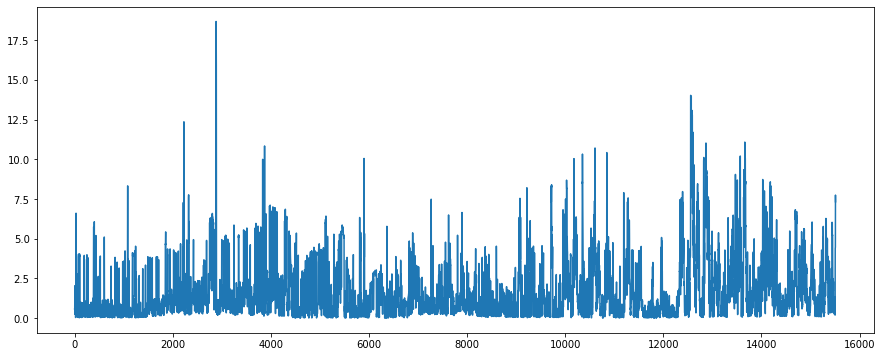

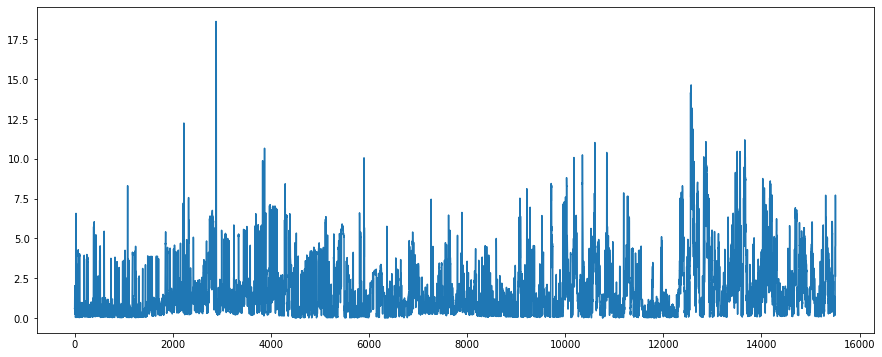

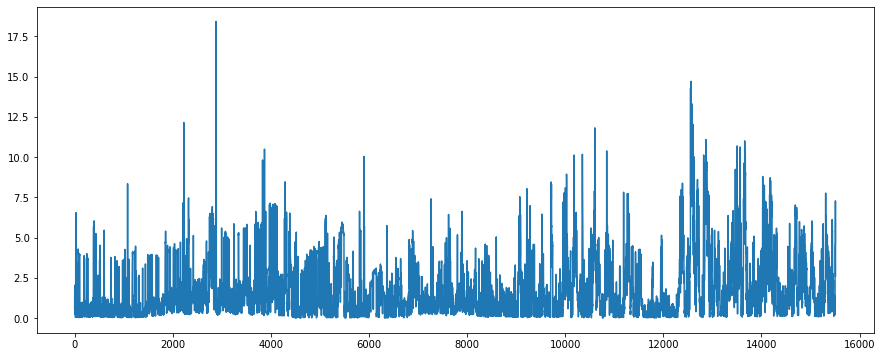

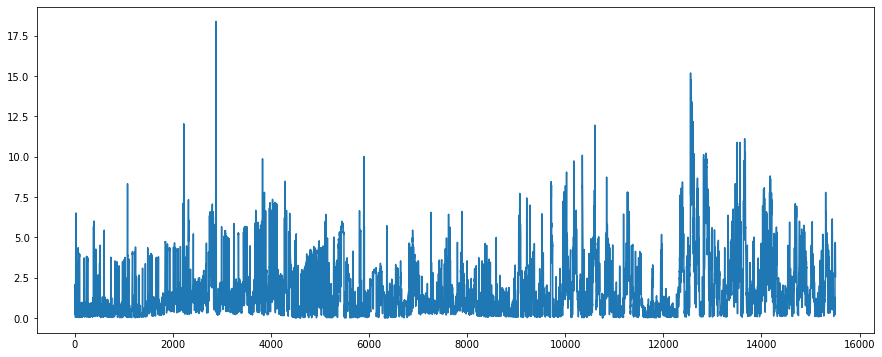

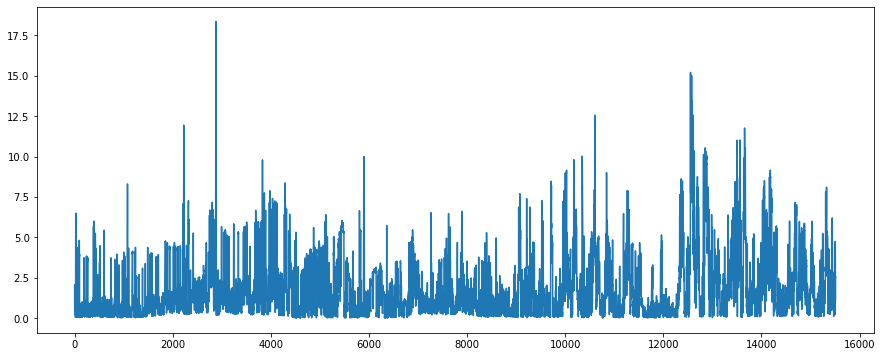

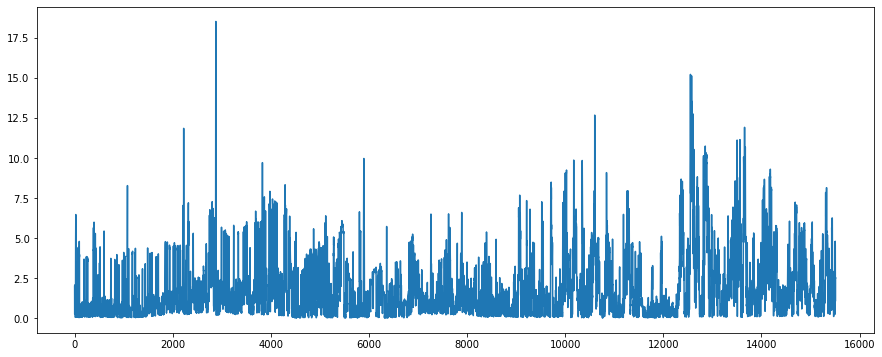

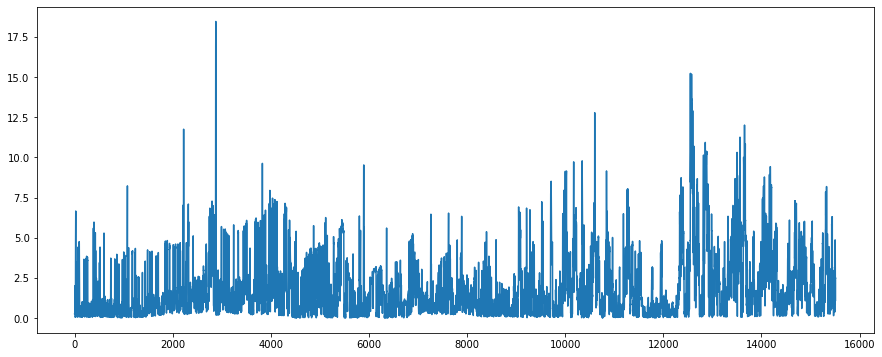

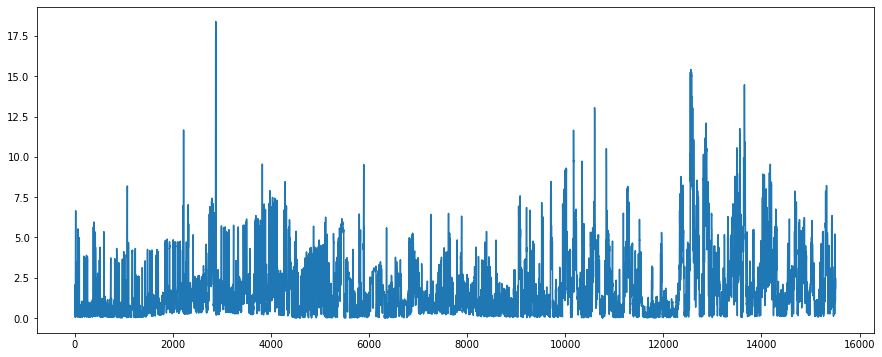

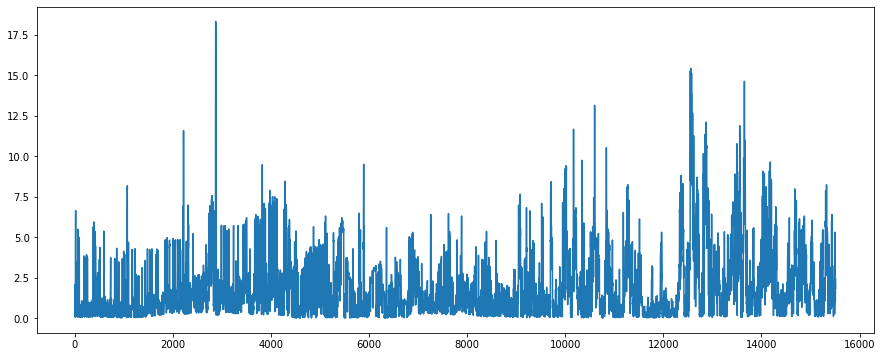

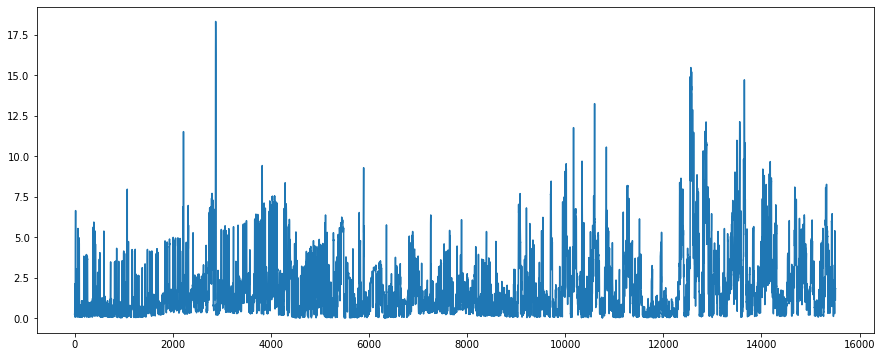

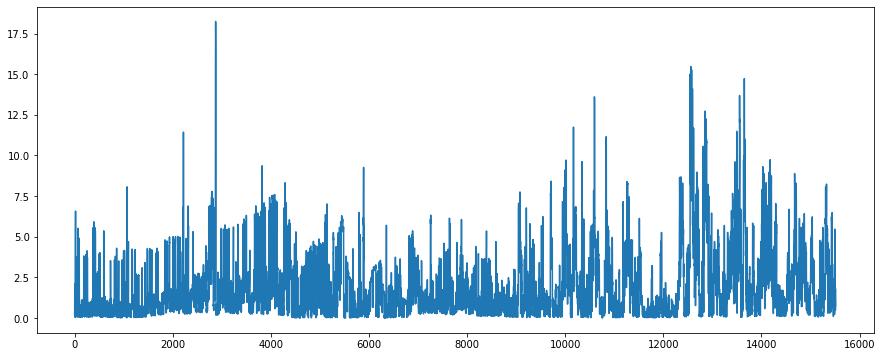

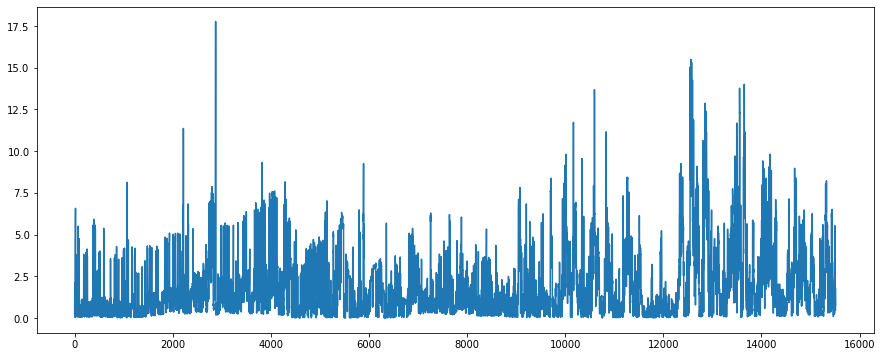

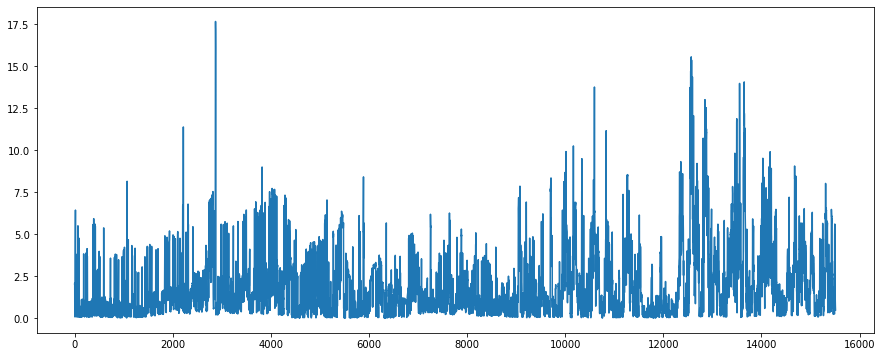

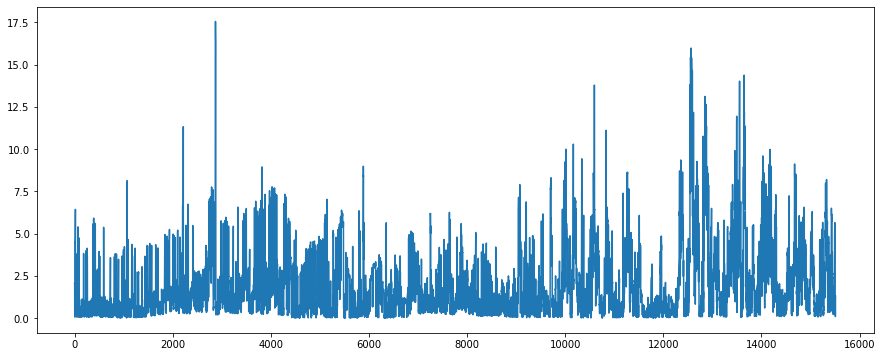

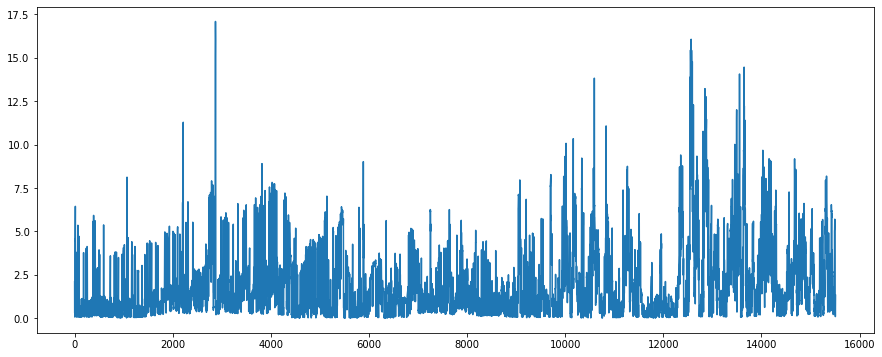

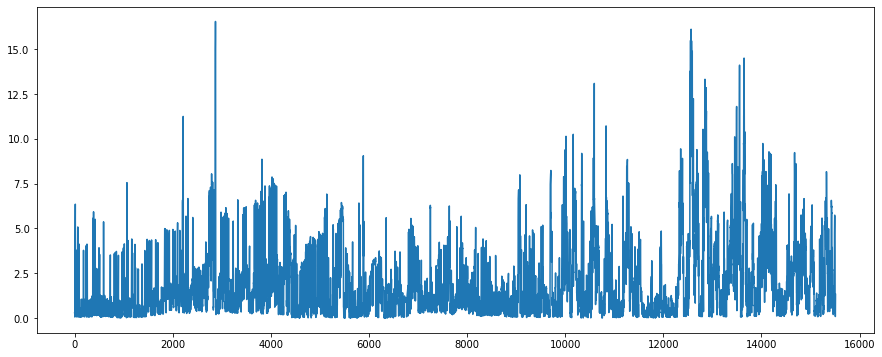

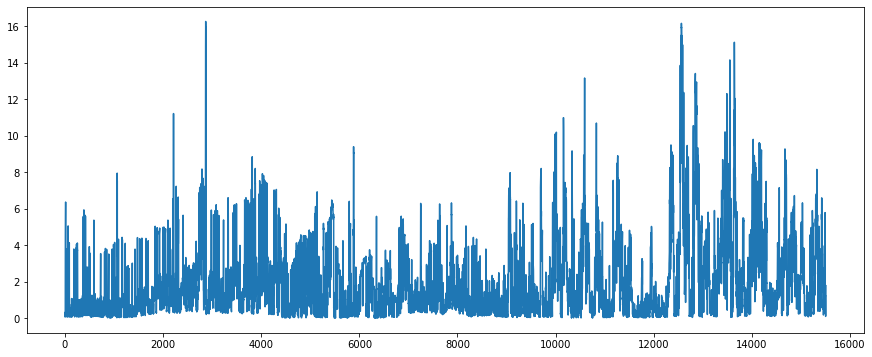

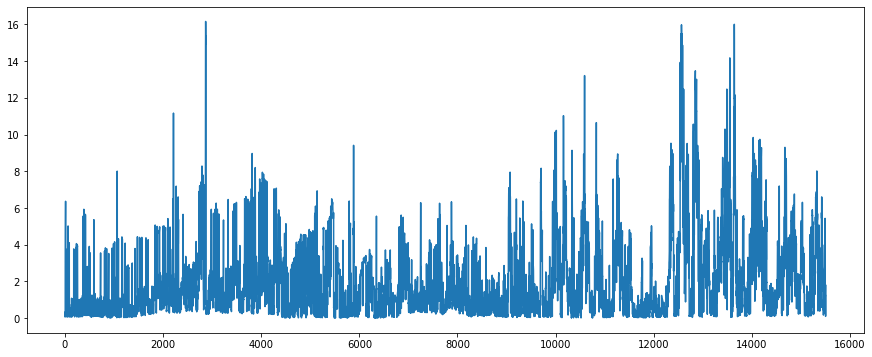

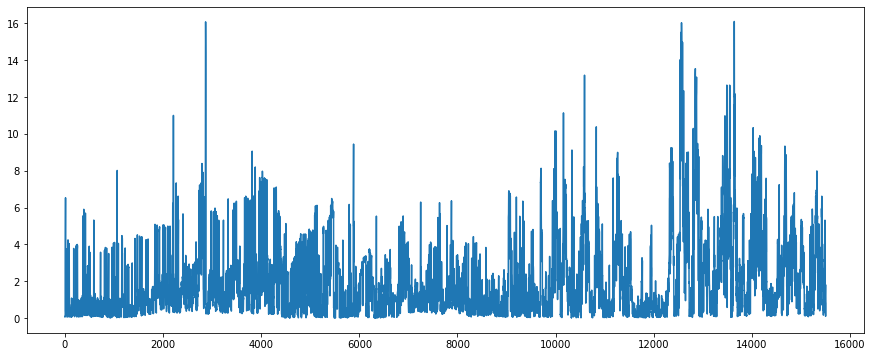

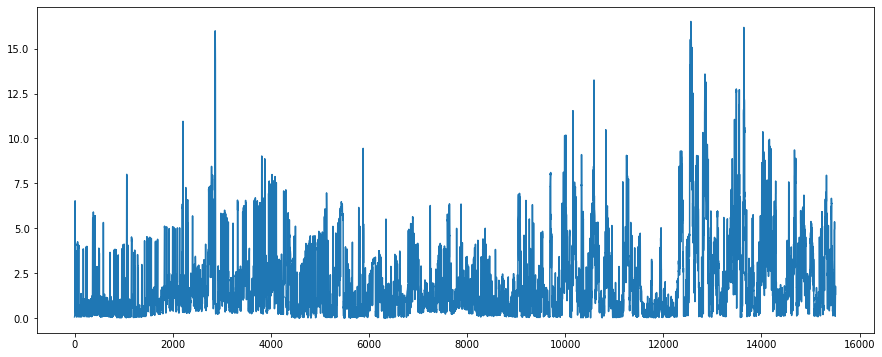

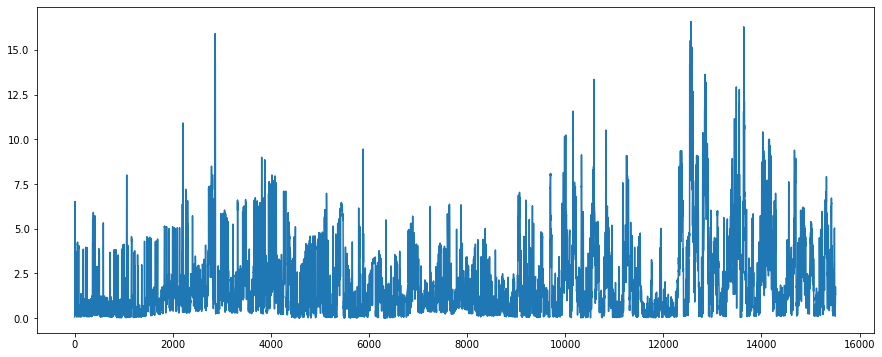

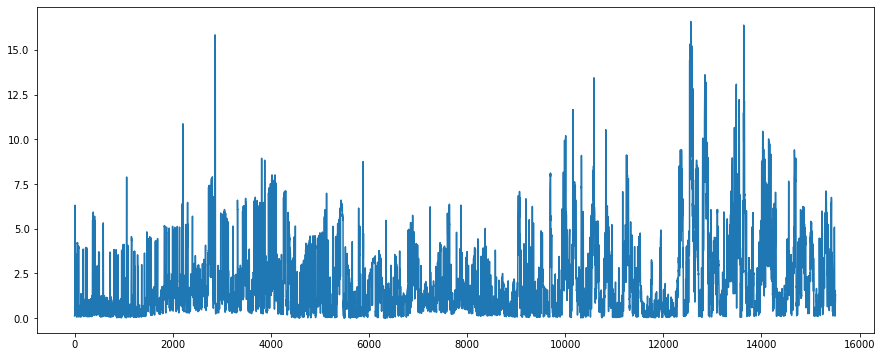

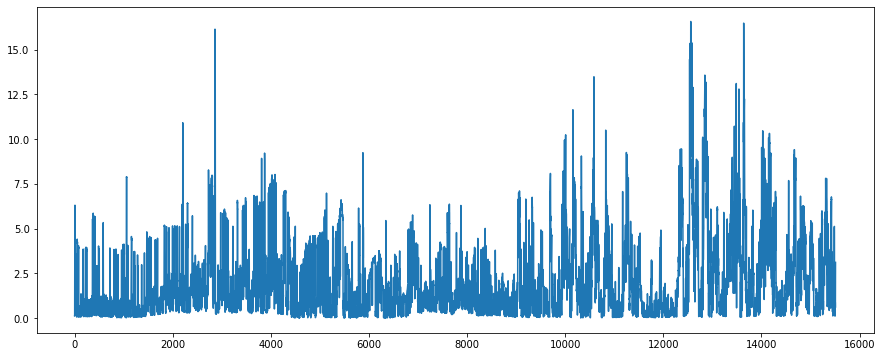

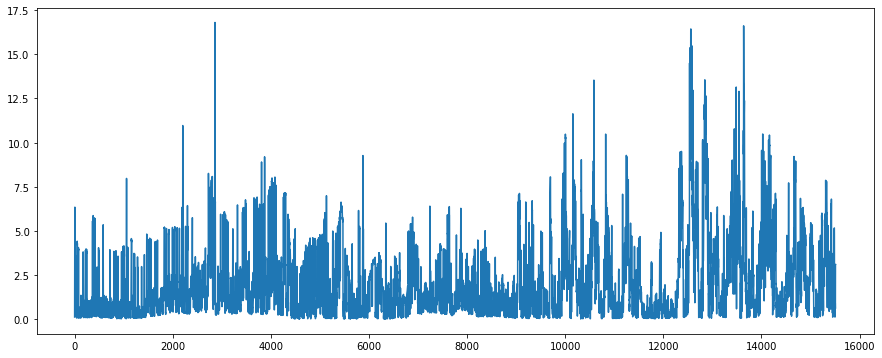

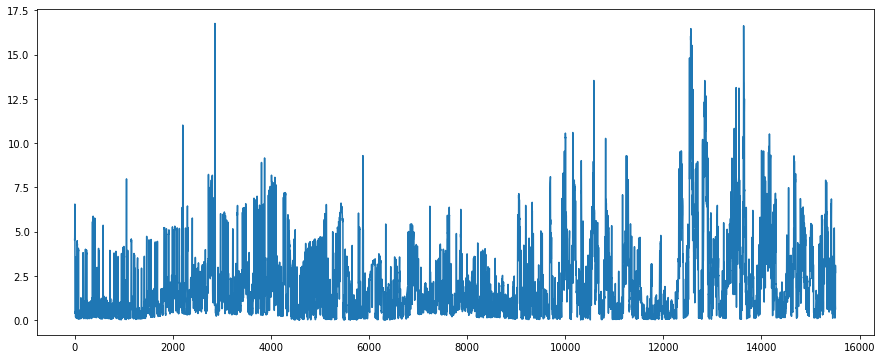

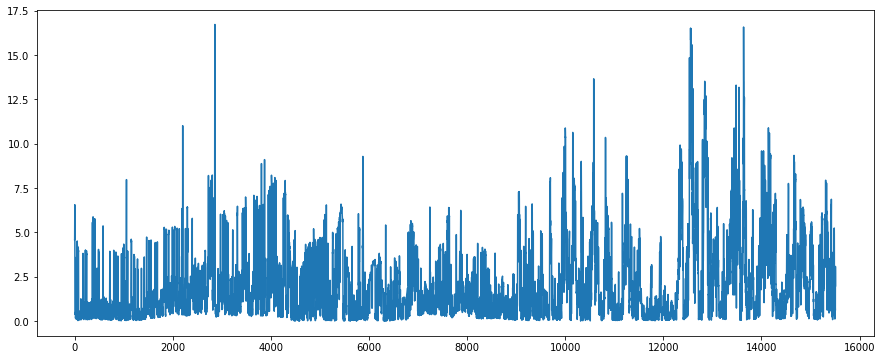

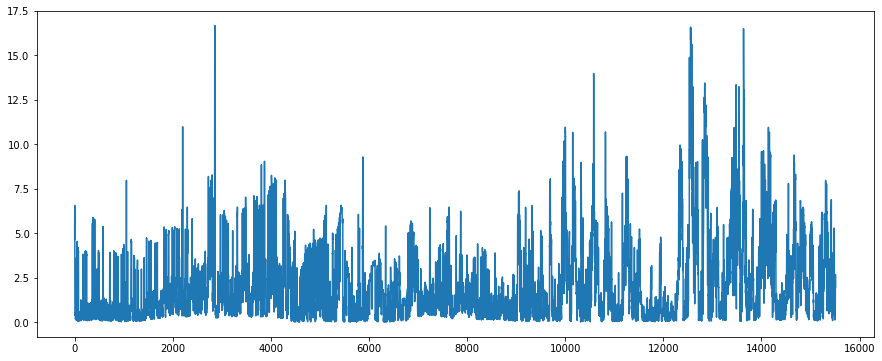

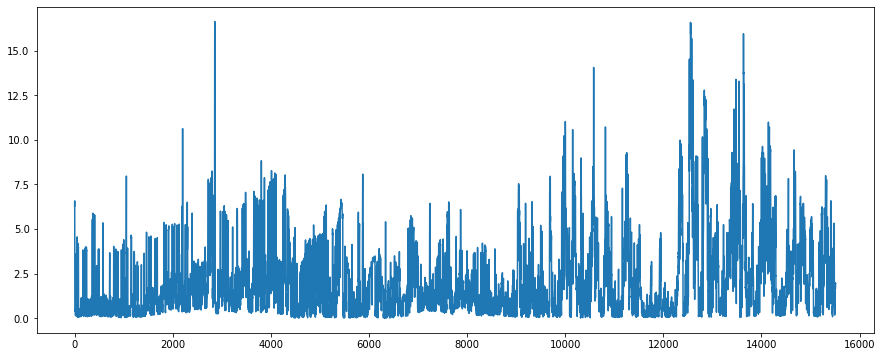

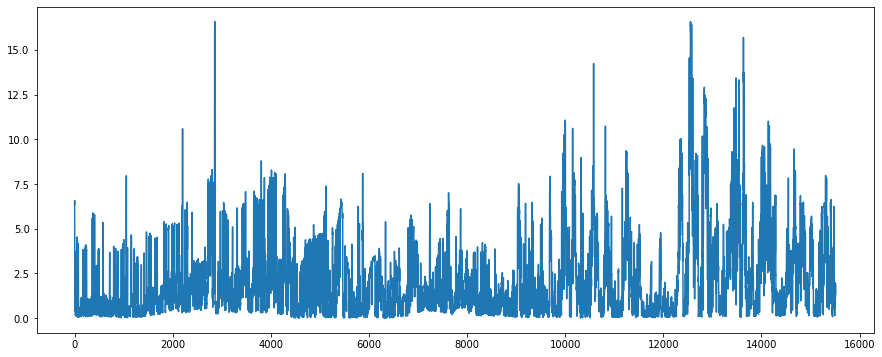

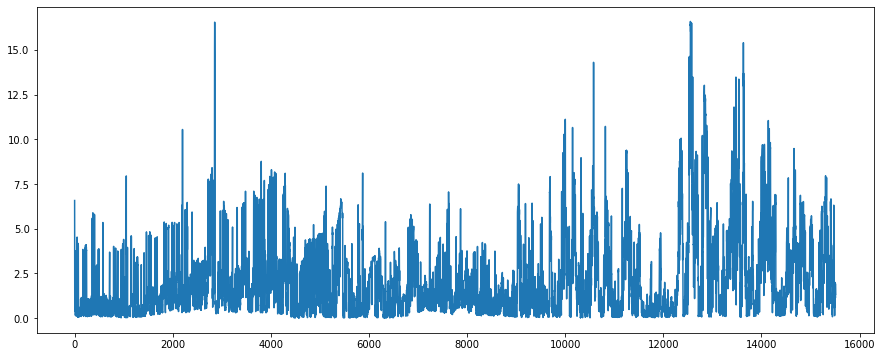

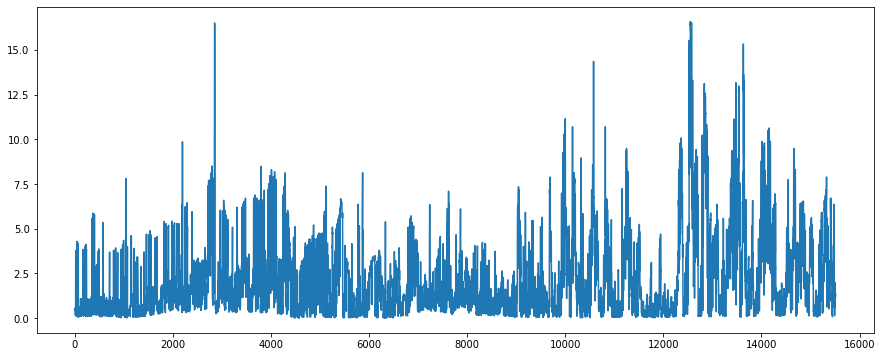

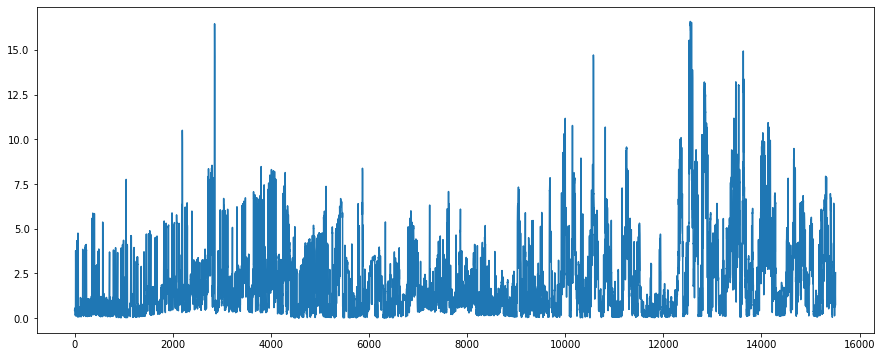

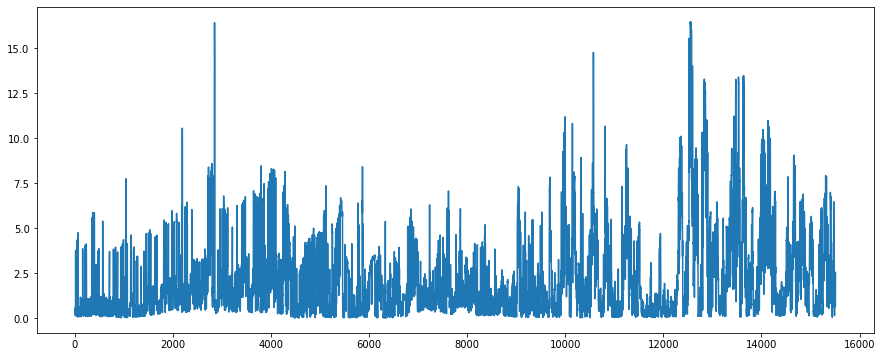

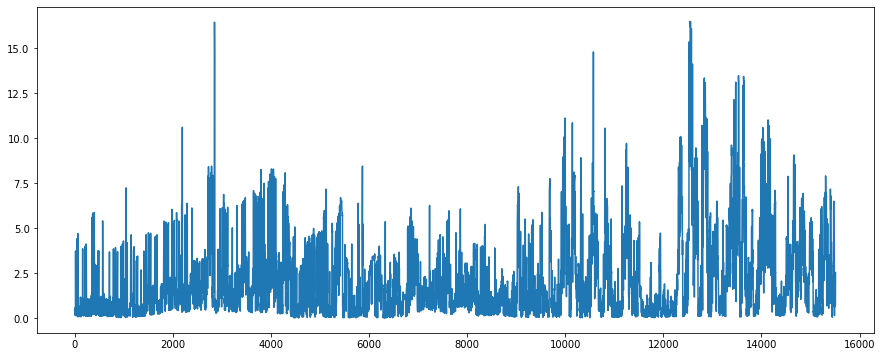

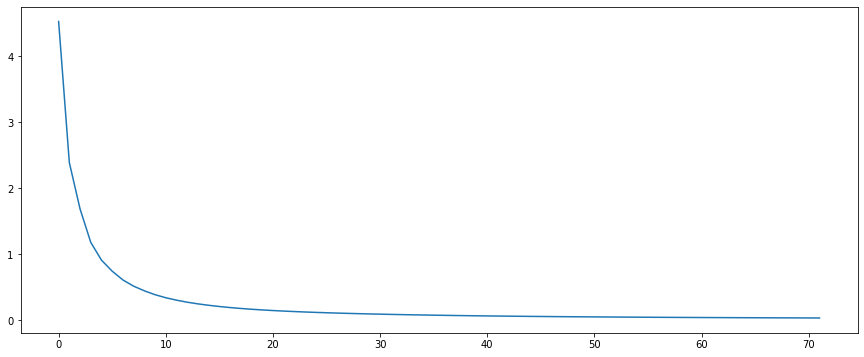

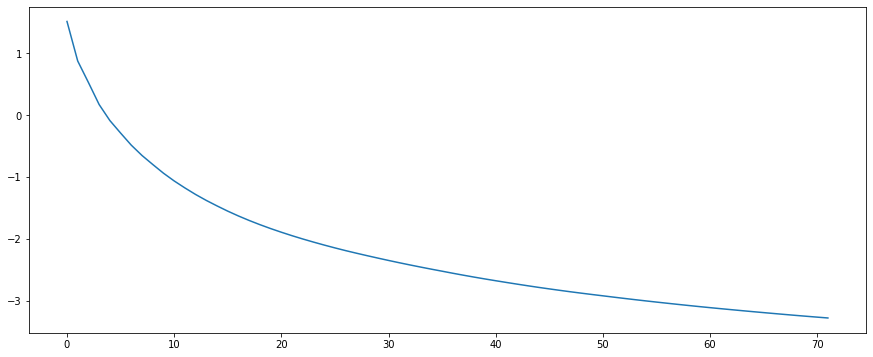

In [7]:
#Future timesteps 

mse_NN = np.zeros((1,pred_number))
mse_ROM = np.zeros((1,pred_number))

x_test_rom = np.copy(x_test)
x_test_NN = np.copy(x_test)
y_test_NN = np.copy(y_test)

for b in range(pred_number):
    y_pred = test_model.predict(x_test_NN)
    y_test_NN = dens_data[split_15-pred_number+b:-pred_number-1+b,:]
    mse_num = 0
    for i in range(len(y_pred)):
        for j in range(len(y_pred[0])):
            mse_num += (y_pred[i][j] - y_test_NN[i][j])**2
    mse_NN[0][b] = mse_num/(y_pred.shape[0]*y_pred.shape[1])
    y_pred_error = abs(y_pred-y_test_NN)
    mse2 = np.zeros(y_pred_error.shape[0])
    for i1 in range(len(y_pred_error)):
        for j1 in range(len(y_pred_error[0])):
            mse2[i1] += y_pred_error[i1][j1]**2
        mse2[i1] = mse2[i1]/(y_pred_error.shape[1])
    plt.figure(figsize=(15,6))
    #title = "NN Prediction Leaky 100 10 6:"+" "+str(b)
    #plt.title(title)
    #pic_title = title + str(".png")
    plt.plot(mse2)
    #plt.savefig(pic_title)
    
    sw_data_test = sw_data[split_15-pred_number+b:-pred_number-1+b,:]
    sw_data_test_append = sw_data[split_15-pred_number+1+b:-pred_number+b,:]
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_NN = np.concatenate((y_pred, sw_data_test), axis=1)

print(mse_NN) 
#print(mse_ROM)

for a in range(pred_number):
    #General
    y_test = dens_data[split_15-pred_number+a:-pred_number-1+a,:]
    sw_data_test = sw_data[split_15-pred_number-1+a:-pred_number-2+a,:]
    sw_data_test_append = sw_data[split_15-pred_number+a:-pred_number-1+a,:]
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    if (a!= 0):
        x_test_rom = np.concatenate((x_test_rom, sw_data_test), axis=1)
    #x_test = np.concatenate((y_test, sw_data_test), axis=1)

    #ROM
    sw_data_test_ROM = x_test_rom[:,10:]
    dens_data_test_ROM = x_test_rom[:,:10]
    XfullPred = np.transpose(np.matmul(A,np.transpose(dens_data_test_ROM)) + np.matmul(B,np.transpose(sw_data_test_ROM)))
    x_test_rom = np.copy(XfullPred)
    errFullPred = abs(XfullPred-y_test)
    mse_rom = 0 
    for x in range(len(errFullPred)):
        for y in range(len(errFullPred[0])):
            mse_rom += errFullPred[x][y]**2
    mse_ROM[0][a] = mse_rom/(errFullPred.shape[0]*errFullPred.shape[1])
    mse_rom2 = np.zeros(errFullPred.shape[0])
    for i2 in range(len(errFullPred)):
        for j2 in range(len(errFullPred[0])):
            mse_rom2[i2] += errFullPred[i2][j2]**2
        mse_rom2[i2] = mse_rom2[i2]/(errFullPred.shape[1])
    plt.figure(figsize=(15,6))
    plt.plot(mse_rom2)
    
print(mse_ROM) 

factor = np.zeros((pred_number))
for i in range(pred_number):
    factor[i] = mse_ROM[0][i]/mse_NN[0][i]
print(factor)

plt.figure(figsize = (15,6))
plt.plot(factor)

factor_log = np.log(factor)
plt.figure(figsize = (15,6))
plt.plot(factor_log)

## Compare errors over recurrent timesteps for model
>for pred_number of hrs

In [1]:
#Future timesteps 

mse_NN = np.zeros((1,pred_number))

x_test_NN = np.copy(x_test)
y_test_NN = np.copy(y_test)

for b in range(pred_number):
    y_pred = test_model.predict(x_test_NN)
    y_test_NN = dens_data[split_15-pred_number+b:-pred_number-1+b,:]
    mse_num = 0
    for i in range(len(y_pred)):
        for j in range(len(y_pred[0])):
            mse_num += (y_pred[i][j] - y_test_NN[i][j])**2
    mse_NN[0][b] = mse_num/(y_pred.shape[0]*y_pred.shape[1])
    y_pred_error = abs(y_pred-y_test_NN)
    mse2 = np.zeros(y_pred_error.shape[0])
    for i1 in range(len(y_pred_error)):
        for j1 in range(len(y_pred_error[0])):
            mse2[i1] += y_pred_error[i1][j1]**2
        mse2[i1] = mse2[i1]/(y_pred_error.shape[1])
    plt.figure(figsize=(15,6))
    #title = "NN Prediction Leaky 100 10 6:"+" "+str(b)
    #plt.title(title)
    #pic_title = title + str(".png")
    plt.plot(mse2)
    #plt.savefig(pic_title)
    
    sw_data_test = sw_data[split_15-pred_number+b:-pred_number-1+b,:]
    sw_data_test_append = sw_data[split_15-pred_number+1+b:-pred_number+b,:]
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_NN = np.concatenate((y_pred, sw_data_test), axis=1)

print(mse_NN) 

factor = np.zeros((pred_number))
for i in range(pred_number):
    factor[i] = mse_ROM[0][i]/mse_NN[0][i]
print(factor)

plt.figure(figsize = (15,6))
plt.plot(factor)


NameError: name 'np' is not defined